In [1]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import sys
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train=pd.read_csv("/kaggle/input/fixed-data-new/train_fixed_new.csv")
test=pd.read_csv("/kaggle/input/fixed-data-new/test_fixed_new.csv")

# 1. Data preparation
Tu ću sad pronaći mašinu koja ima najveći seasonality koristeći seasonal_decompose.


In [3]:
seasonality=dict()
for machine in train.machine_name.unique() :
    machine_data = train[train['machine_name'] == machine]['total']

    decomposition = seasonal_decompose(machine_data, model='additive', period=int(np.floor(len(machine_data)/2)))
    seasonal_component = decomposition.seasonal

    seasonality[machine]=abs(seasonal_component).mean()

seasonality = dict(sorted(seasonality.items(), key=lambda x: x[1], reverse=True))
masina, value = next(iter(seasonality.items()))
print("Najveci seasonality ima:" + masina)

Najveci seasonality ima:CI101712


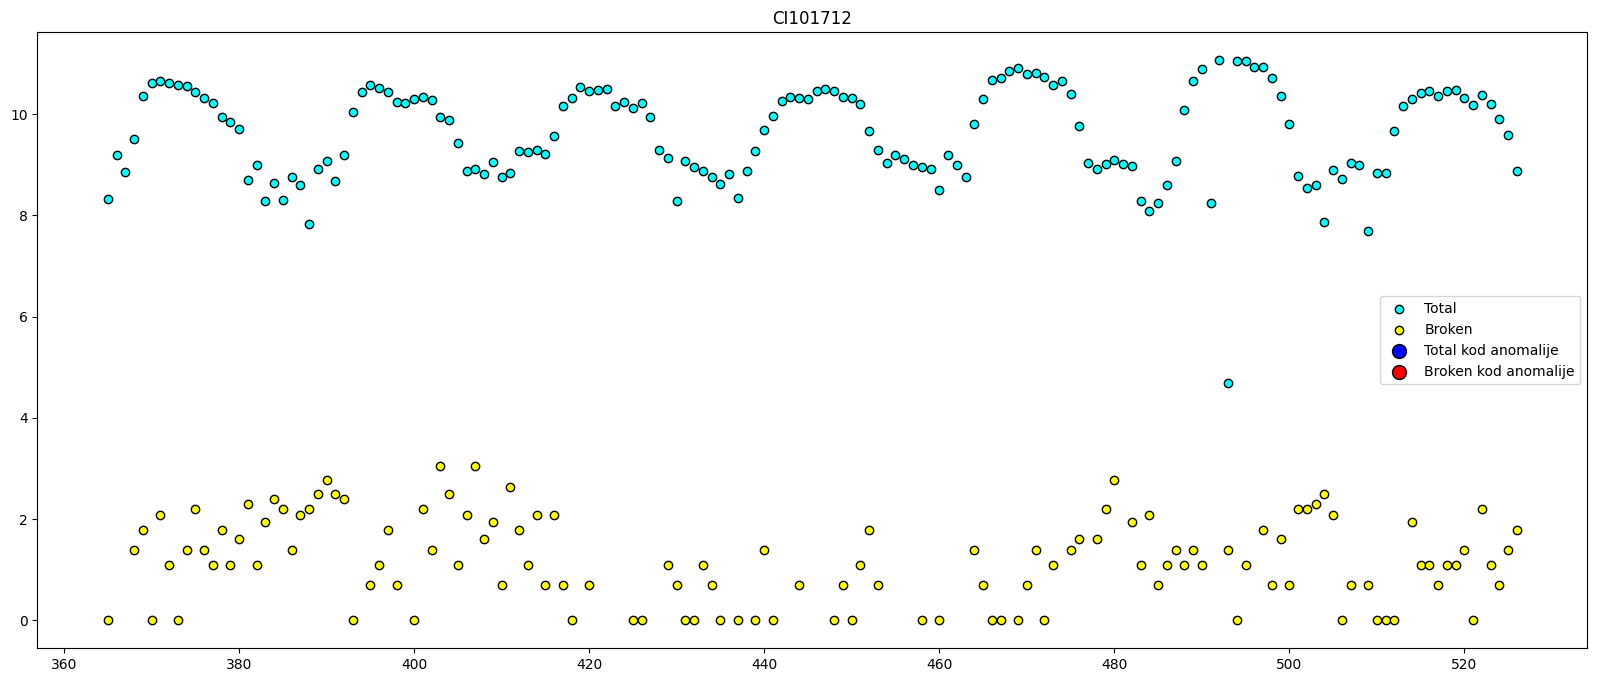

In [4]:
def visualizeData(machine_name):    
    machine_data=train.loc[(train['machine_name']==machine_name) & (train['day']>364)]
    plt.figure(figsize=(20, 8))
    
    total= []
    broken=[]
    anomalija_day=[]
    anomalija_total=[]
    anomalija_broken=[]
    for index, row in machine_data.iterrows():
        total.append(row['total'])
        broken.append(row['broken'])
        
        if row['label']==1:
            anomalija_total.append(row['total'])
            anomalija_broken.append(row['broken'])
            anomalija_day.append(row['day'])
        

    plt.title(machine_name)
    plt.scatter(range(365,365+len(total)), np.log(total), c='cyan', edgecolors= "black", label='Total')
    plt.scatter(range(365,365+len(broken)), np.log(broken), c='yellow',edgecolors= "black", label='Broken')
    plt.scatter(anomalija_day, np.log(anomalija_total), c='b', s=100, edgecolors= "black", label='Total kod anomalije')
    plt.scatter(anomalija_day, np.log(anomalija_broken), c='r', s=100, edgecolors= "black", label='Broken kod anomalije')
    
    plt.legend(loc='best')
    plt.show()
    return

visualizeData('CI101712')

# 2. Exponential smoothing
Ovdje ću sad raditi exponential smoothing na podatcima odabrane mašine.

In [5]:
machine_data = train[train['machine_name'] == 'CI101712']['total']

train_size = int(len(machine_data) * 0.7)
train_data = machine_data[:train_size]
test_data = machine_data[train_size:]
train_values = train_data.values
test_values = test_data.values

In [6]:
model = ExponentialSmoothing(train_values).fit()
pred = model.predict(start=len(train_values), end=len(train_values) + len(test_values) - 1)
rmse=mean_squared_error(test_values, pred, squared=False)
mae=mean_absolute_error(test_values, pred)

print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

RMSE: 22614.68041192595
MAE: 15460.117117625701


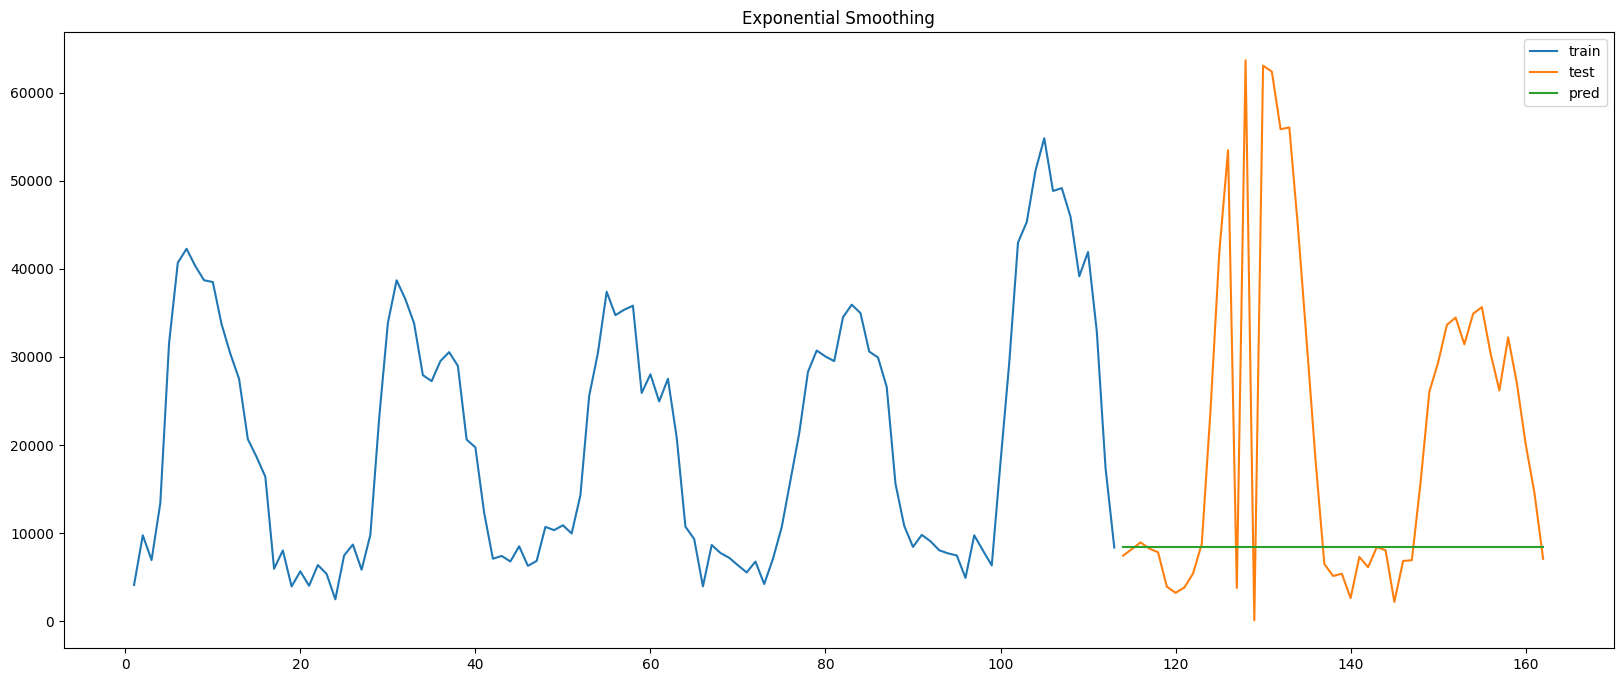

In [7]:
plt.figure(figsize=(20,8))
plt.plot(range(1, len(train_values)+1), train_values, label='train')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), test_values, label='test')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), pred, label='pred')
plt.title('Exponential Smoothing')
plt.legend()
plt.show()

Predviđanje je samo ravna linija, iz koje ne možemo izvući ništa informacija, to je tako jer pri inicijalizaciji Exponential Smoothing modela nisam modificirao nikakve parametre, te nisam modelu dao informaciju koliko često se pojavljuju periodi.

Za seasonal_periods sam odabrao 23 jer je 162 dana, a gore se vidi 7 perioda.

Parametri:
Soothing_level: 0, Soothing_slope: 0, Soothing_seasonal: 0
RMSE: 17363.474907419215
MAE: 13184.616088487193

Parametri:
Soothing_level: 0, Soothing_slope: 0, Soothing_seasonal: 1
RMSE: 14706.385333297525
MAE: 10268.551020408164

Parametri:
Soothing_level: 0, Soothing_slope: 0, Soothing_seasonal: 0
RMSE: 17363.474907419215
MAE: 13184.616088487193

Parametri:
Soothing_level: 0, Soothing_slope: 0, Soothing_seasonal: 5
RMSE: 15842.679739934074
MAE: 10782.317629101382

Parametri:
Soothing_level: 0, Soothing_slope: 0, Soothing_seasonal: 1
RMSE: 14706.385333297525
MAE: 10268.551020408164

Parametri:
Soothing_level: 0, Soothing_slope: 0.1, Soothing_seasonal: 0
RMSE: 17363.474907419215
MAE: 13184.616088487193

Parametri:
Soothing_level: 0, Soothing_slope: 0.1, Soothing_seasonal: 1
RMSE: 14706.385333297525
MAE: 10268.551020408164

Parametri:
Soothing_level: 0, Soothing_slope: 0.1, Soothing_seasonal: 0
RMSE: 17363.474907419215
MAE: 13184.616088487193

Parametri:
Soothing_level: 0, Soot

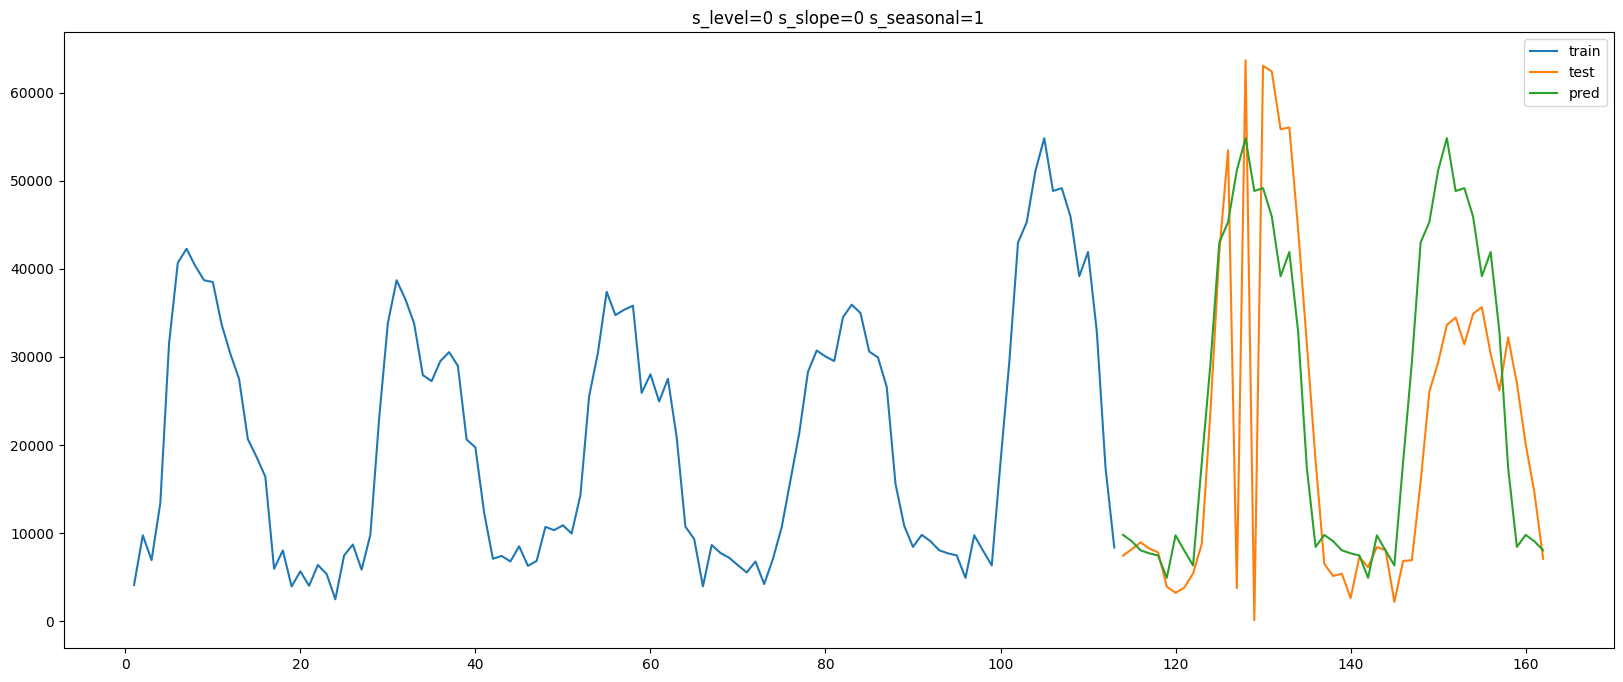

In [8]:
best_level=0
best_slope=0
best_seasonal=0
best_error=sys.maxsize
for smoothing_level in [0, 0.1, 0.5]:
    for smoothing_slope in [0, 0.1, 0.5]:
        for smoothing_seasonal in [0,1, 0,5, 1]:
            model = ExponentialSmoothing(train_values, seasonal='add', seasonal_periods=23).fit(
                smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, smoothing_seasonal=smoothing_seasonal)

            pred = model.predict(start=len(train_values), end=len(train_values) + len(test_values) - 1)
            rmse=mean_squared_error(test_values, pred, squared=False)
            mae=mean_absolute_error(test_values, pred)
            
            print("Parametri:")
            print("Soothing_level: "+str(smoothing_level), end="")
            print(", Soothing_slope: "+str(smoothing_slope), end="")
            print(", Soothing_seasonal: "+str(smoothing_seasonal))
            print("RMSE: "+str(rmse))
            print("MAE: "+str(mae))
            print()
            
            
            if rmse < best_error:
                best_level=smoothing_level
                best_slope=smoothing_slope
                best_seasonal=smoothing_seasonal
                best_error=rmse

print()
print("Najbolji parametri:")
print("Smoothing_level: "+str(best_level))
print("Smoothing_slope: "+str(best_slope))
print("Smoothing_seasonal: "+str(best_seasonal))


model = ExponentialSmoothing(train_values, seasonal='add', seasonal_periods=23).fit(
                smoothing_level=best_level, smoothing_slope=best_slope, smoothing_seasonal=best_seasonal)
pred = model.predict(start=len(train_values), end=len(train_values) + len(test_values) - 1)

rmse=mean_squared_error(test_values, pred, squared=False)
mae=mean_absolute_error(test_values, pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(train_values)+1), train_values, label='train')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), test_values, label='test')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), pred, label='pred')
plt.title('s_level='+str(best_level)+' s_slope='+str(best_slope)+' s_seasonal='+str(best_seasonal))
plt.legend()
plt.show()

Parametar smoothing_level utječe na komponentu razine(njegovom promjenom graf se diže ili spušta), što je veći funkcija je pod većim utjecajem promjena u podatcima.

Parametar smoothing_slope utječe na trend funkcije predikcije, što je veći funkcija je pod većim utjecajem promjena trenda u podatcima.

Parametar smoothing_seasonal utječe koliko se pažnje pridaje zadnjem periodu.

Vidi se da je najbolji rezultat za (0,0,1), a to se vidi i na grafu jer su 2 zadnja perioda ista kao zadnji period train skupa.

# 3. ARIMA
Ovdje ću sad pokušati predvidjeti kretanje podataka koristeći ARIMA-u.

In [9]:
machine_data = train[train['machine_name'] == 'CI101712']['total']

train_size = int(len(machine_data) * 0.7)
train_data = machine_data[:train_size]
test_data = machine_data[train_size:]
train_values = train_data.values
test_values = test_data.values

RMSE: 18518.11883396383
MAE: 15749.596893624705


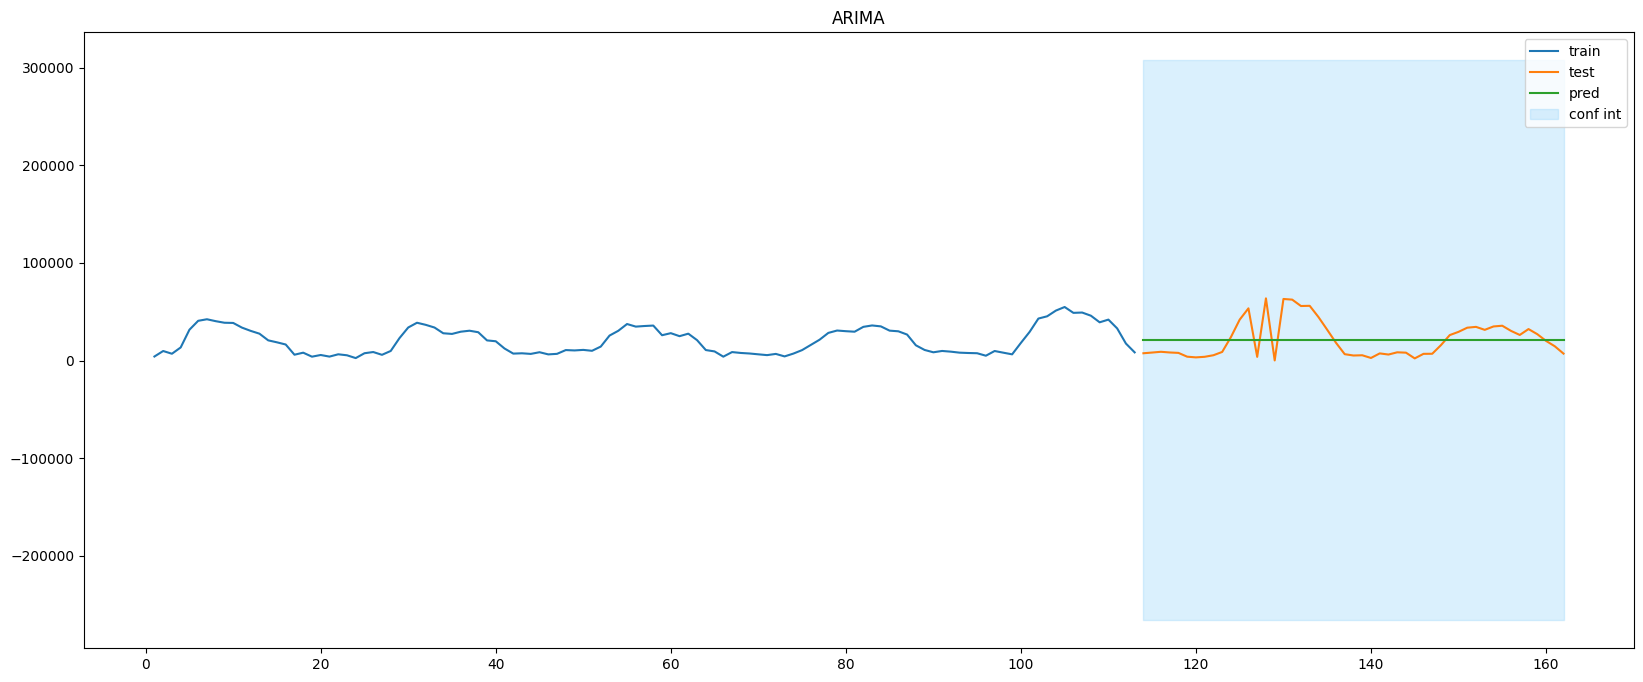

In [10]:
model = ARIMA(train_data, order=(0, 0, 0)).fit()
pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

forecast = model.get_forecast(steps=len(test_data))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse=mean_squared_error(test_values, pred, squared=False)
mae=mean_absolute_error(test_values, pred)

print("RMSE: "+str(rmse))
print("MAE: "+str(mae))


plt.figure(figsize=(20,8))        
plt.plot(range(1, len(train_values)+1), train_values, label='train')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), test_values, label='test')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), pred, label='pred')
plt.fill_between(range(len(train_values)+1, len(train_values)+len(test_values)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA")
plt.legend()
plt.show()

Kao i kod exponential Smoothinga-a, ne možemo ništa zaključiti iz dobivenih podataka, to je tako jer ni ovdje nisam koristio nikakve parametre.

Ispod ću provesti pokušaj pronalaska optimalnih vrijednosti za parametre p, d, q, njihovu kombinaciju te za parametar s.

P: 0
RMSE: 18518.11883396383
MAE: 15749.596893624705

P: 1
RMSE: 18448.88946984987
MAE: 14367.412856313395

P: 2
RMSE: 17811.17924998304
MAE: 14387.401161134849

P: 5
RMSE: 17035.384277169713
MAE: 14190.533766248385

P: 10
RMSE: 13018.178147637835
MAE: 9808.818162387286

P: 15
RMSE: 12716.45993889777
MAE: 9530.069446217352

P: 20
RMSE: 12553.77934595487
MAE: 9446.209924355951

P: 23
RMSE: 11564.704493900103
MAE: 7896.3629188525965

P: 25
RMSE: 11536.880143380105
MAE: 7171.660810728433


Najbolji parametri:
P: 25
RMSE: 11536.880143380105
MAE: 7171.660810728433


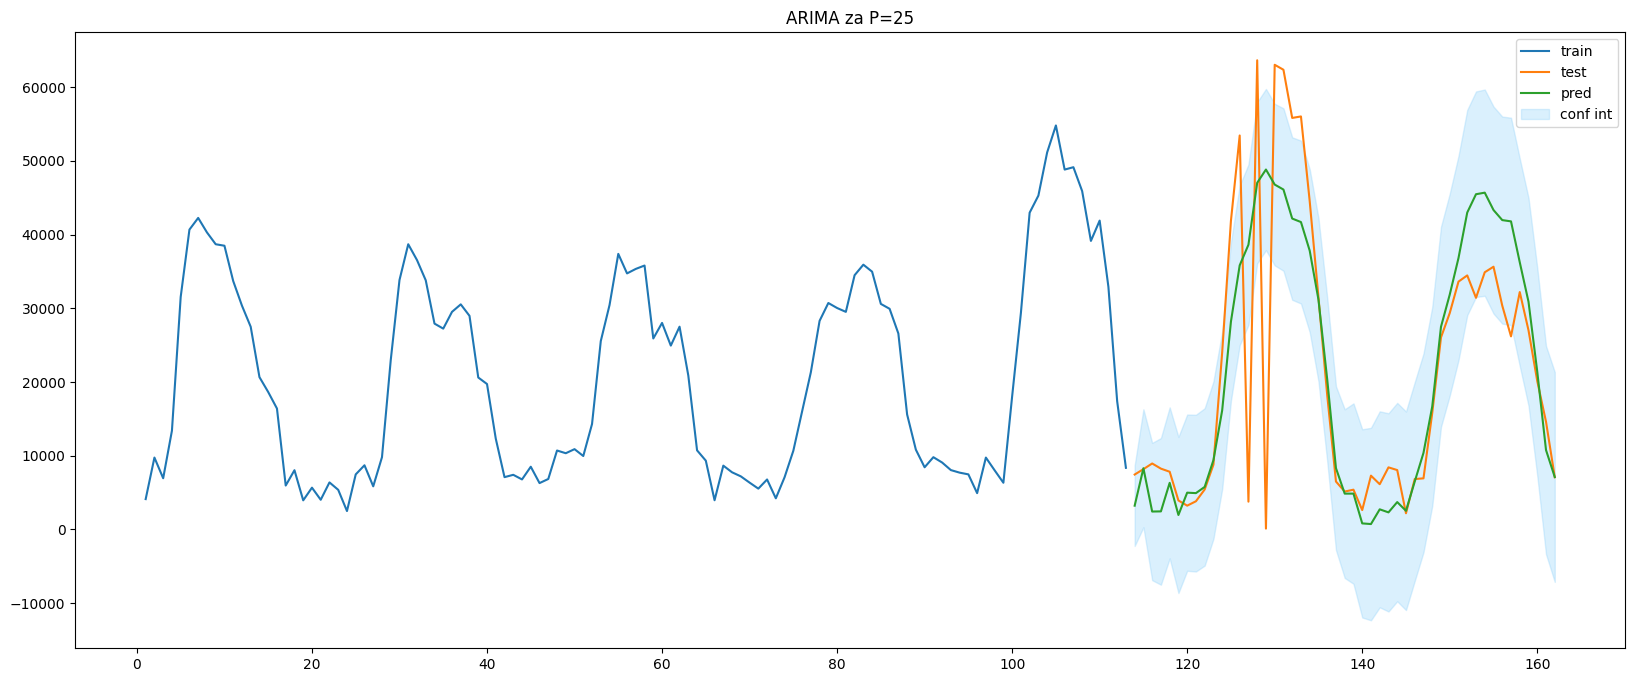

In [11]:
best_p=0
best_error=sys.maxsize
for p in [0, 1, 2, 5, 10, 15, 20, 23, 25]:
    model = ARIMA(train_data, order=(p, 0, 0)).fit()
    pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

    rmse=mean_squared_error(test_values, pred, squared=False)
    mae=mean_absolute_error(test_values, pred)

    print("P: "+str(p))
    print("RMSE: "+str(rmse))
    print("MAE: "+str(mae))
    print()
                
    if rmse < best_error:
        best_p=p
        best_error=rmse

print()
print("Najbolji parametri:")
print("P: "+str(best_p))

model = ARIMA(train_data, order=(best_p, 0, 0)).fit()
pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

forecast = model.get_forecast(steps=len(test_data))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse=mean_squared_error(test_values, pred, squared=False)
mae=mean_absolute_error(test_values, pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(train_values)+1), train_values, label='train')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), test_values, label='test')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), pred, label='pred')
plt.fill_between(range(len(train_values)+1, len(train_values)+len(test_values)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA za P="+str(best_p))
plt.legend()
plt.show()

Parametar p znaci koliko se dana unazad gleda za računanje nove predikcije, najbolji rezultat dolazi za p=23, a to ima smisla jer se period pojavljuje svaka 23 dana pa ovako promatra čiji period.

Q: 0
RMSE: 18518.11883396383
MAE: 15749.596893624705

Q: 1
RMSE: 18436.427469659695
MAE: 15545.65252614144

Q: 2
RMSE: 18484.270636119916
MAE: 15657.65134566012

Q: 5
RMSE: 18201.67835049421
MAE: 14939.868879465816

Q: 10
RMSE: 18889.53885529413
MAE: 15692.932728675018

Q: 15
RMSE: 17986.788295613576
MAE: 14608.651763174847

Q: 20
RMSE: 15600.802327830275
MAE: 13009.1638091855

Q: 23
RMSE: 18044.76725365548
MAE: 14942.522442709098

Q: 25
RMSE: 16184.807876515617
MAE: 13410.846368926623


Najbolji parametri:
Q: 20
RMSE: 15600.802327830275
MAE: 13009.1638091855


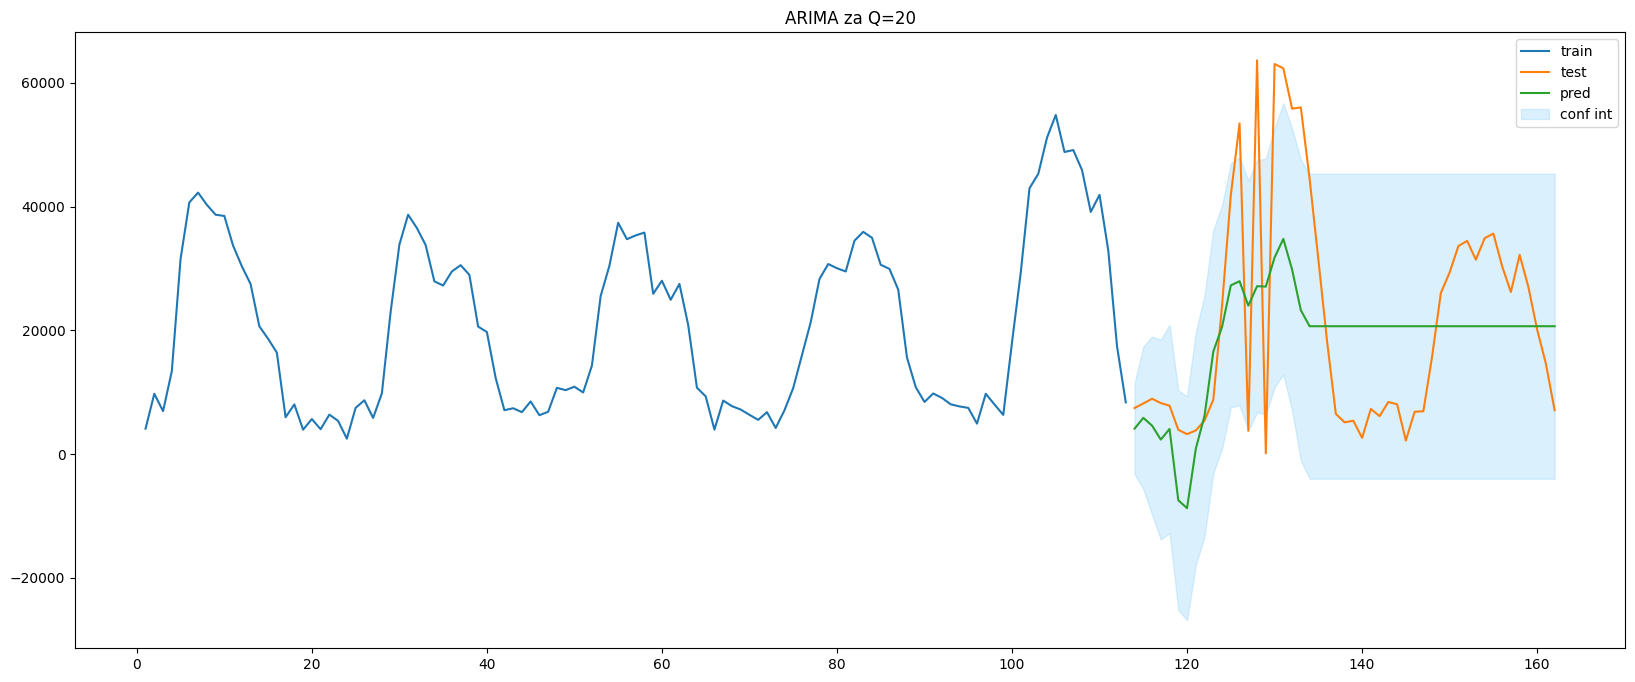

In [12]:
best_q=0
best_error=sys.maxsize
for q in [0, 1, 2, 5, 10, 15, 20, 23, 25]:
    model = ARIMA(train_data, order=(0, 0, q)).fit()
    pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

    rmse=mean_squared_error(test_values, pred, squared=False)
    mae=mean_absolute_error(test_values, pred)

    print("Q: "+str(q))
    print("RMSE: "+str(rmse))
    print("MAE: "+str(mae))
    print()
                
    if rmse < best_error:
        best_q=q
        best_error=rmse

print()
print("Najbolji parametri:")
print("Q: "+str(best_q))

model = ARIMA(train_data, order=(0, 0, best_q)).fit()
pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

forecast = model.get_forecast(steps=len(test_data))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse=mean_squared_error(test_values, pred, squared=False)
mae=mean_absolute_error(test_values, pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(train_values)+1), train_values, label='train')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), test_values, label='test')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), pred, label='pred')
plt.fill_between(range(len(train_values)+1, len(train_values)+len(test_values)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA za Q="+str(best_q))
plt.legend()
plt.show()

Prametar q broj dana unazad čije pogreške i reziduale model gleda, najbolji rezultat dolazi za q=20.

D: 0
RMSE: 18518.11883396383
MAE: 15749.596893624705

D: 1
RMSE: 22640.924744491207
MAE: 15466.632653061224

D: 2
RMSE: 272814.18729159125
MAE: 239143.3673469388

D: 3
RMSE: 3385523.818489583
MAE: 2506849.795918368

D: 4
RMSE: 110062527.3397204
MAE: 74154981.63265342

D: 5
RMSE: 848116375.2548404
MAE: 526335346.63266087

D: 6
RMSE: 16638994882.28289
MAE: 9379173067.592693

D: 7
RMSE: 637969092891.547
MAE: 339037333012.2284

D: 8
RMSE: 11495837812491.787
MAE: 5779848526683.982

D: 9
RMSE: 144867794536954.6
MAE: 69322964595435.91


Najbolji parametri:
D: 0
RMSE: 18518.11883396383
MAE: 15749.596893624705


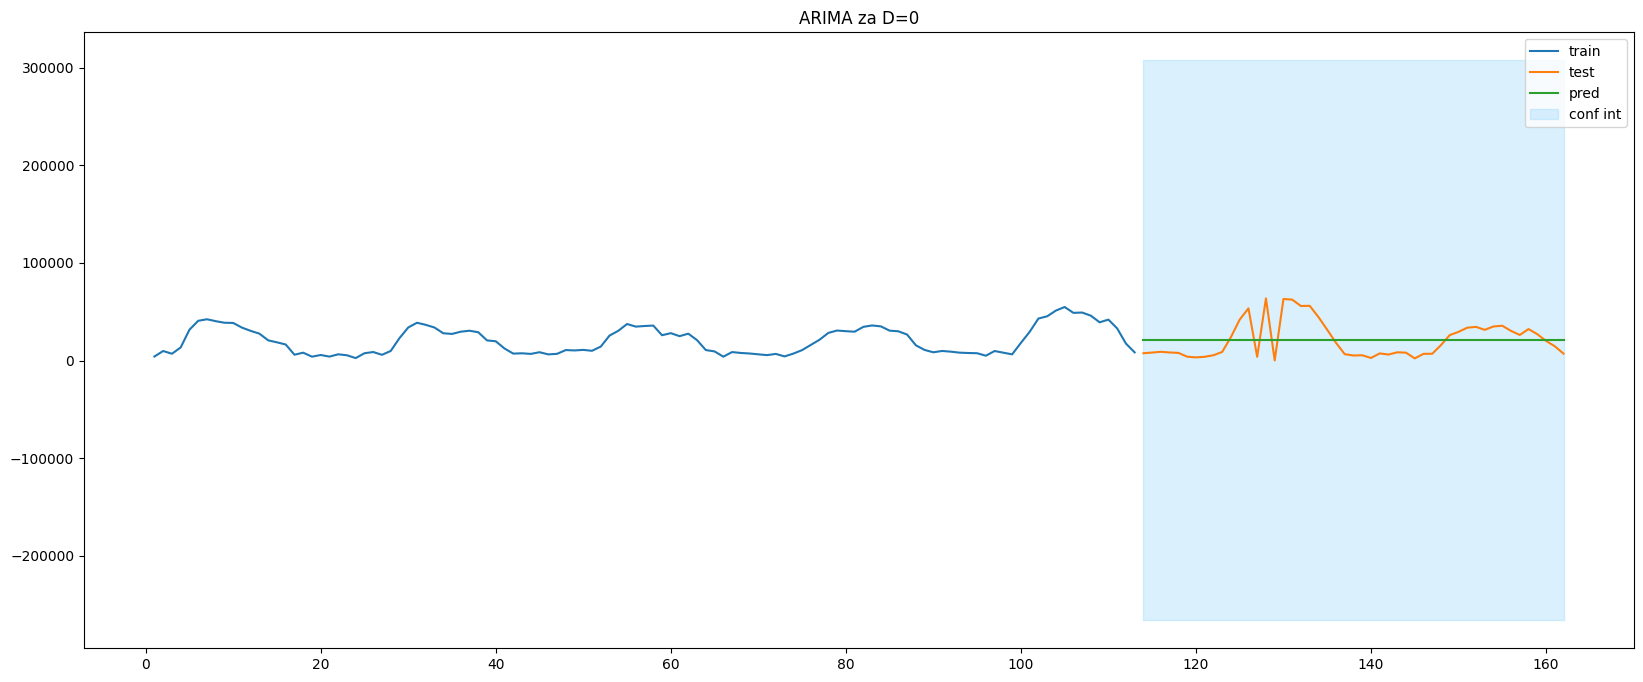

In [13]:
best_d=0
best_error=sys.maxsize
for d in range(10):
    model = ARIMA(train_data, order=(0, d, 0)).fit()
    pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

    rmse=mean_squared_error(test_values, pred, squared=False)
    mae=mean_absolute_error(test_values, pred)

    print("D: "+str(d))
    print("RMSE: "+str(rmse))
    print("MAE: "+str(mae))
    print()
                
    if rmse < best_error:
        best_d=d
        best_error=rmse

print()
print("Najbolji parametri:")
print("D: "+str(best_d))

model = ARIMA(train_data, order=(0, best_d, 0)).fit()
pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

forecast = model.get_forecast(steps=len(test_data))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse=mean_squared_error(test_values, pred, squared=False)
mae=mean_absolute_error(test_values, pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(train_values)+1), train_values, label='train')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), test_values, label='test')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), pred, label='pred')
plt.fill_between(range(len(train_values)+1, len(train_values)+len(test_values)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA za D="+str(best_d))
plt.legend()
plt.show()

Parametar d je koliko se puta primjenjuje stacioniranje podataka tako da se maknu trendovi i periodičnost, najbolji rezultat dolazi za 0 jer u ovom slučaju ne želimo micati periodičnost.

Parametri:
P: 15, D: 0, Q: 10
RMSE: 12984.799489890203
MAE: 9856.824943335225

Parametri:
P: 15, D: 0, Q: 15
RMSE: 15803.93891423311
MAE: 12514.367480235916

Parametri:
P: 15, D: 0, Q: 20
RMSE: 17728.615404514698
MAE: 14249.766435787236

Parametri:
P: 15, D: 1, Q: 10
RMSE: 12944.972727190025
MAE: 9852.37796280737

Parametri:
P: 15, D: 1, Q: 15
RMSE: 16882.504135707855
MAE: 12860.8507365351

Parametri:
P: 15, D: 1, Q: 20
RMSE: 19243.859666090993
MAE: 15460.004603804304

Parametri:
P: 15, D: 2, Q: 10
RMSE: 16488.954165614534
MAE: 11809.47060773142

Parametri:
P: 15, D: 2, Q: 15
RMSE: 15991.794652730567
MAE: 11639.636630958217

Parametri:
P: 15, D: 2, Q: 20
RMSE: 16404.213147453665
MAE: 12938.590902493359

Parametri:
P: 20, D: 0, Q: 10
RMSE: 14010.369922737602
MAE: 10641.642721133498

Parametri:
P: 20, D: 0, Q: 15
RMSE: 15111.71448810541
MAE: 11264.781693928277

Parametri:
P: 20, D: 0, Q: 20
RMSE: 17133.744075823804
MAE: 14105.295614138215

Parametri:
P: 20, D: 1, Q: 10
RMSE: 15477.000954

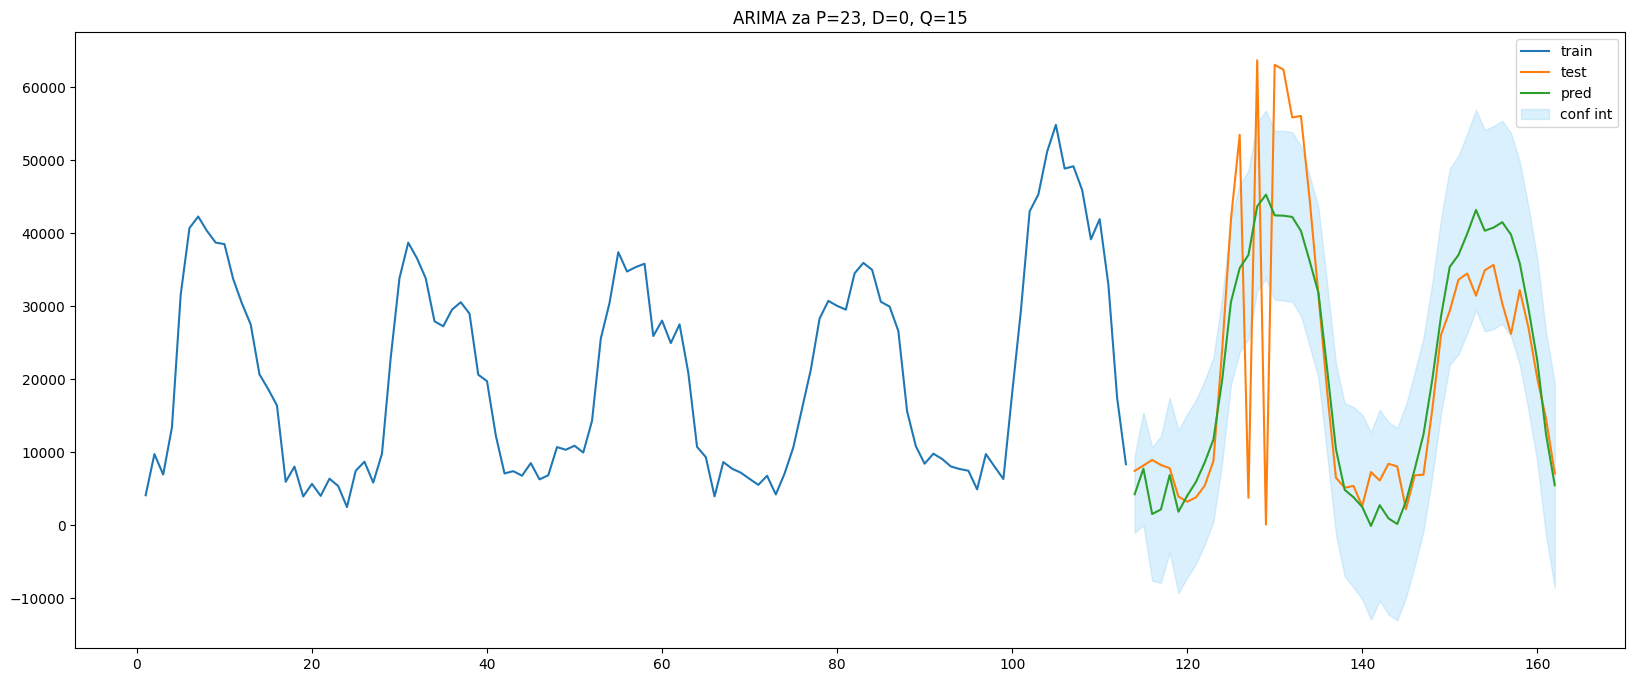

In [14]:
best_p=0
best_d=0
best_q=0
best_error=sys.maxsize

for p in [15, 20, 23]:
    for d in range(3):
        for q in [10, 15, 20]:
            model = ARIMA(train_data, order=(p, d, q)).fit()
            pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

            rmse=mean_squared_error(test_values, pred, squared=False)
            mae=mean_absolute_error(test_values, pred)
            
            print("Parametri:")
            print("P: "+str(p), end="")
            print(", D: "+str(d), end="")
            print(", Q: "+str(q))
            
            print("RMSE: "+str(rmse))
            print("MAE: "+str(mae))
            print()

            if rmse < best_error:
                best_p=p
                best_d=d
                best_q=q
                best_error=rmse

print("Najbolji parametri:")
print("P: "+str(best_p))
print("D: "+str(best_d))
print("Q: "+str(best_q))

model = ARIMA(train_data, order=(best_p, best_d, best_q)).fit()
pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

forecast = model.get_forecast(steps=len(test_data))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse=mean_squared_error(test_values, pred, squared=False)
mae=mean_absolute_error(test_values, pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(train_values)+1), train_values, label='train')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), test_values, label='test')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), pred, label='pred')
plt.fill_between(range(len(train_values)+1, len(train_values)+len(test_values)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA za P="+str(best_p)+", D="+str(best_d)+", Q="+str(best_q))
plt.legend()
plt.show()

Najbolji rezultat dolazi za kombinaciju parametara, (p,d,q)=(23, 0, 15)

S: 4
RMSE: 11690.709966680168
MAE: 7182.197923427956

S: 5
RMSE: 11876.714963317821
MAE: 7660.745711199756

S: 6
RMSE: 11453.698673187597
MAE: 6652.166516549006

S: 7
RMSE: 12218.638164548882
MAE: 7822.079161300068


Najbolji parametri:
S: 6
RMSE: 11453.698673187597
MAE: 6652.166516549006


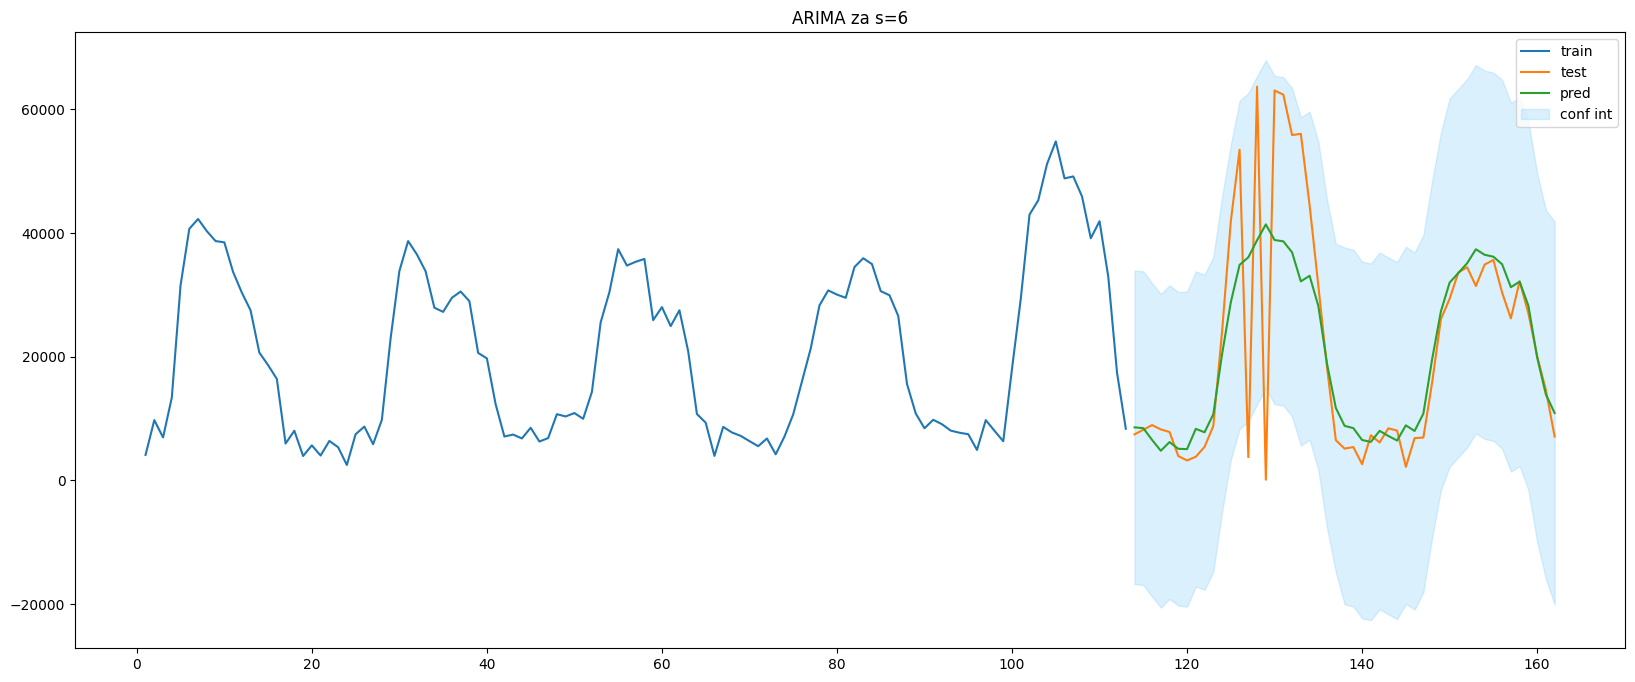

In [15]:
best_s=0
best_error=sys.maxsize
for s in range(4, 8):
    model = ARIMA(train_data, order=(0, 0, 0), seasonal_order=(23,0,15,s)).fit()
    pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

    rmse=mean_squared_error(test_values, pred, squared=False)
    mae=mean_absolute_error(test_values, pred)

    print("S: "+str(s))
    print("RMSE: "+str(rmse))
    print("MAE: "+str(mae))
    print()
                
    if rmse < best_error:
        best_s=s
        best_error=rmse

print()
print("Najbolji parametri:")
print("S: "+str(best_s))

model = ARIMA(train_data, order=(0, 0, 0), seasonal_order=(23,0,15,best_s)).fit()
pred = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

forecast = model.get_forecast(steps=len(test_data))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse=mean_squared_error(test_values, pred, squared=False)
mae=mean_absolute_error(test_values, pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(train_values)+1), train_values, label='train')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), test_values, label='test')
plt.plot(range(len(train_values)+1, len(train_values)+len(test_values)+1), pred, label='pred')
plt.fill_between(range(len(train_values)+1, len(train_values)+len(test_values)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA za s="+str(best_s))
plt.legend()
plt.show()

Parametar s predstavlja frekvenciju perioda, a najbolji rezultat dolazi za s=6.

# 4. Facbook Propeth
Ovdje ću sad predviđati korištenjem facebook propheta. Import-ao sam ga iz biblioteke prophet, a ne fbprophet jer je su promijenili ime biblioteke, u starim bilježnicama poput na primjer ove: https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet funkcionira import sa fbprophet, al u novima ne pa ja importam s prophet.


In [16]:
from prophet import Prophet

Ovdje ću sad dodati stupac sa datumima krenuvši od 15.6.2018.

In [17]:
machine_data = train[train['machine_name'] == 'CI101712']
machine_data=machine_data.reset_index()
start_date = pd.to_datetime('2018-06-15 00:00:00')
machine_data['ds'] = pd.date_range(start=start_date, periods=len(machine_data), freq='24H')
machine_data = machine_data.rename(columns={'total': 'y'})

train_size = int(len(machine_data) * 0.7)
train_data = machine_data[:train_size]
test_data = machine_data[train_size:]

14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing


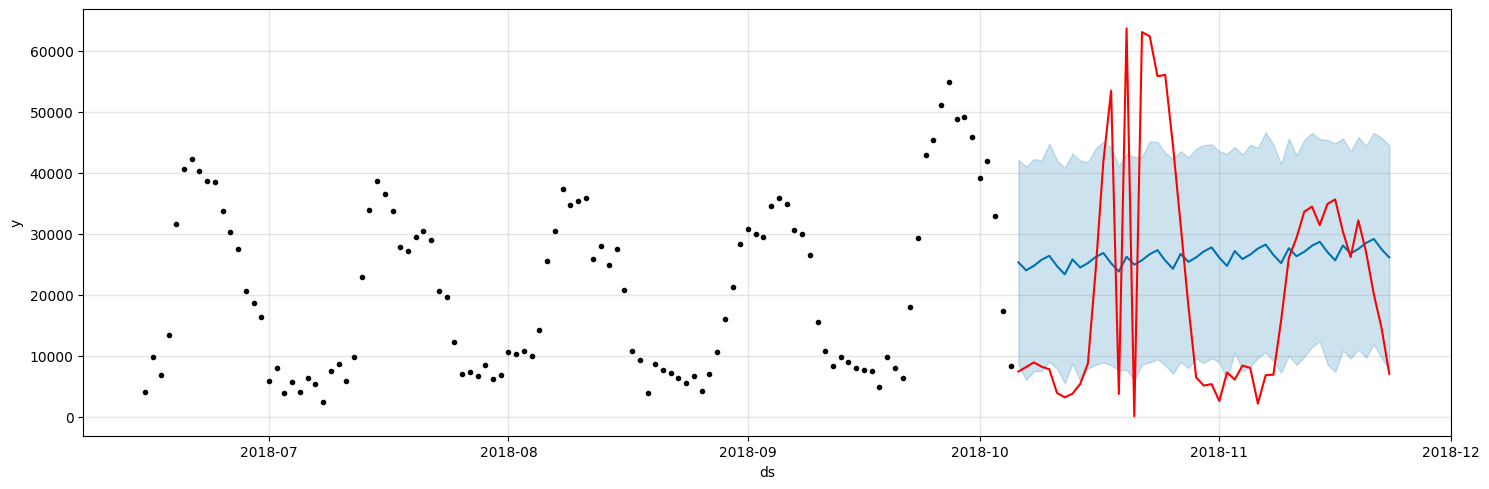

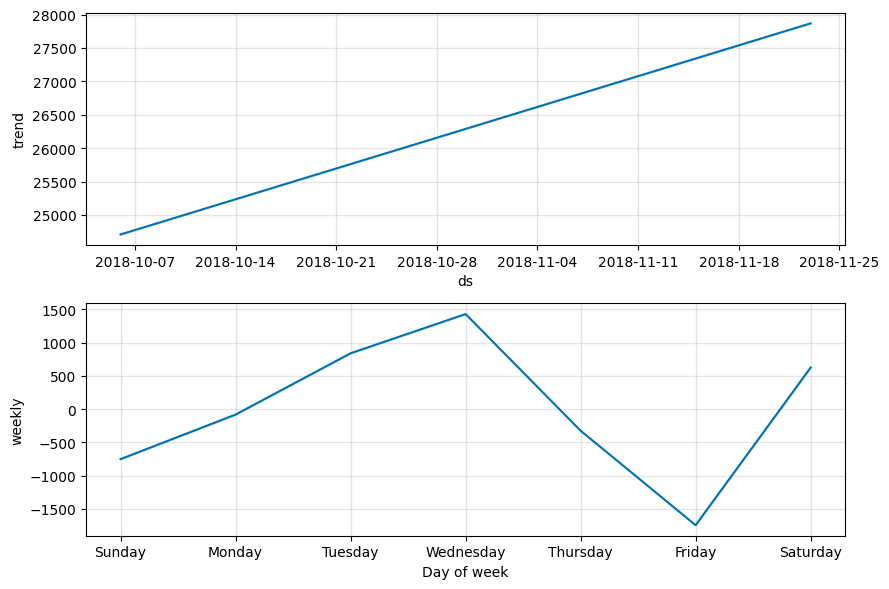

In [18]:
model = Prophet().fit(train_data)
pred = model.predict(df=test_data)

figure, ax = plt.subplots(1)
figure.set_figheight(5)
figure.set_figwidth(15)
fig=model.plot(pred,ax=ax)
ax.plot(test_data.ds, test_data['y'], color='r')
plt.show()
fig = model.plot_components(pred)

Vidi se samo tjedna komponenta i komponenta trenda koja linearno raste.

In [19]:
y_pred = pred['yhat']
y_true = test_data['y'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

RMSE: 18935.06559253273
MAE: 16368.013492821583


Tu koristim period 23 izračunat ranije.

14:37:55 - cmdstanpy - INFO - Chain [1] start processing
14:37:55 - cmdstanpy - INFO - Chain [1] done processing
14:37:55 - cmdstanpy - INFO - Chain [1] start processing
14:37:55 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 1
RMSE: 17766.661260745197
MAE: 14309.278517212968



14:37:56 - cmdstanpy - INFO - Chain [1] start processing
14:37:56 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 2
RMSE: 17710.03506596893
MAE: 14221.491811457861



14:37:56 - cmdstanpy - INFO - Chain [1] start processing
14:37:56 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 3
RMSE: 18492.333096170805
MAE: 15205.851134834315



14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 4
RMSE: 18389.29287128724
MAE: 15105.872651149164



14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 5
RMSE: 18487.397148760767
MAE: 15208.190971968826



14:37:57 - cmdstanpy - INFO - Chain [1] start processing
14:37:57 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 6
RMSE: 18431.116212052613
MAE: 15110.734813394065



14:37:58 - cmdstanpy - INFO - Chain [1] start processing
14:37:58 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 7
RMSE: 18556.350587511166
MAE: 15338.123753592976



14:37:58 - cmdstanpy - INFO - Chain [1] start processing
14:37:58 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 8
RMSE: 18550.732911729516
MAE: 15326.923920592508



14:37:59 - cmdstanpy - INFO - Chain [1] start processing
14:37:59 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 9
RMSE: 18617.808001849702
MAE: 15418.177773168705



14:37:59 - cmdstanpy - INFO - Chain [1] start processing
14:37:59 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 10
RMSE: 18415.737743450685
MAE: 15205.907673960692


Najbolji parametri:
Fourier order: 2
RMSE: 18415.737743450685
MAE: 15205.907673960692


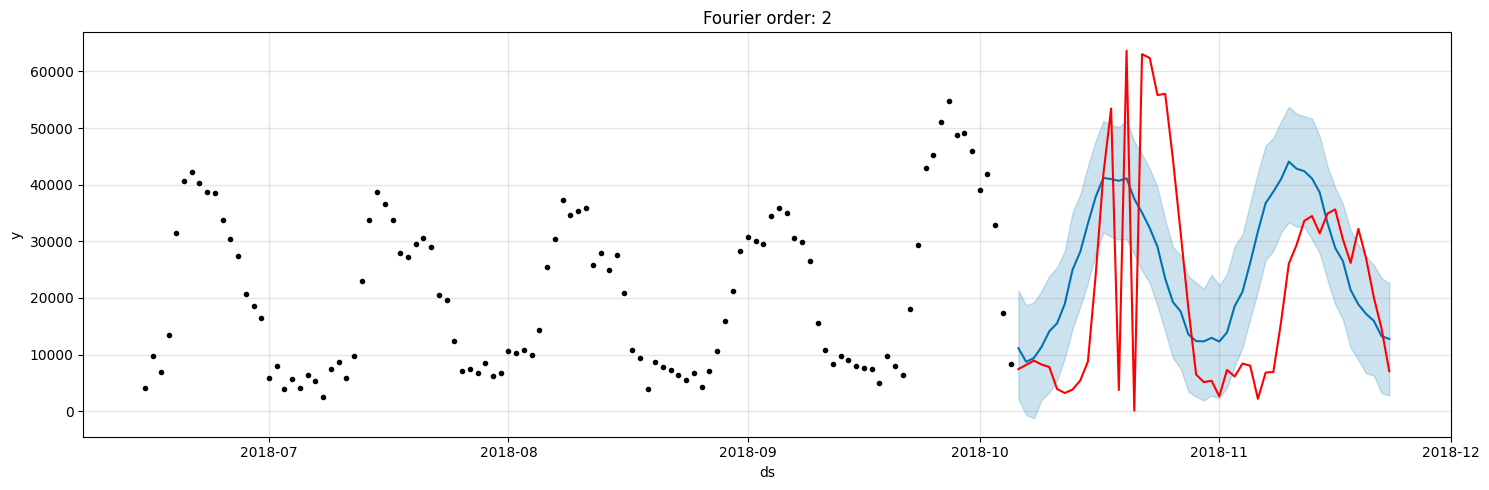

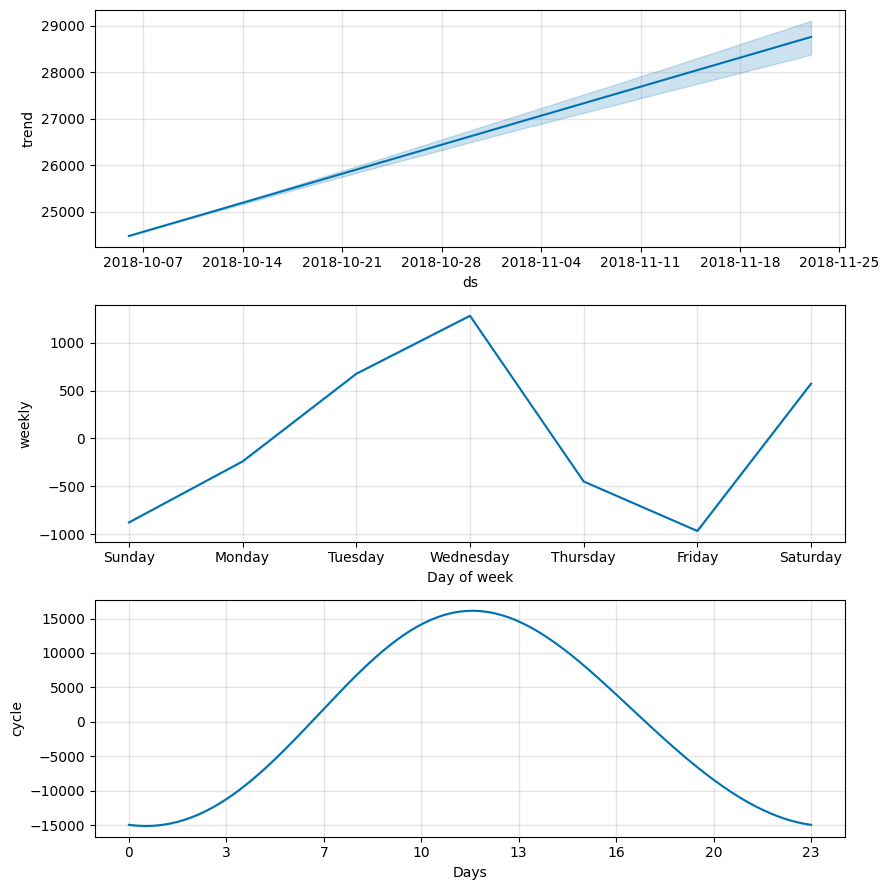

In [20]:
best_order=0
best_error=sys.maxsize

for f_order in range(1, 11):

    model = Prophet()
    model.add_seasonality(name='cycle', period=23, fourier_order=f_order)
    model.fit(train_data)
    pred = model.predict(df=test_data)
    
    y_pred = pred['yhat']
    y_true = test_data['y'].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print("Fourier order: "+str(f_order))
    print("RMSE: "+str(rmse))
    print("MAE: "+str(mae))
    print()
                
    if rmse < best_error:
        best_order=f_order
        best_error=rmse

print()
print("Najbolji parametri:")
print("Fourier order: "+str(best_order))

model = Prophet()
model.add_seasonality(name='cycle', period=23, fourier_order=best_order)
model.fit(train_data)
pred = model.predict(df=test_data)  

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

figure, ax = plt.subplots(1)
plt.title("Fourier order: "+str(best_order))
figure.set_figheight(5)
figure.set_figwidth(15)
fig=model.plot(pred,ax=ax)
ax.plot(test_data.ds, test_data['y'], color='r')
plt.show()

fig = model.plot_components(pred)

Dodao sam periodičnost prije fitanja tako da model zna koji su periodi, periodičnost se pojavljuje svaka 23 dana, a najbolja je za Fourierov red 2. Vidi se poboljšanje predikcije i smanjenje pogreške.

# 5. RandomForestRegressor
Sada ću predviđati kretanje podataka korištenjem RandomForestRegressora. On će korištenjem drugih značajki predviđati total.

In [21]:
machine_data = train[train['machine_name'] == 'CI101712']
X=machine_data.drop(['total', 'machine_name'], axis=1)
y=machine_data['total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [22]:
rfr = RandomForestRegressor().fit(X_train, y_train)
y_pred = rfr.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("RMSE: " +str(rmse))
print("MAE: "+ str(mae))

RMSE: 19164.762424034045
MAE: 15056.810816326533


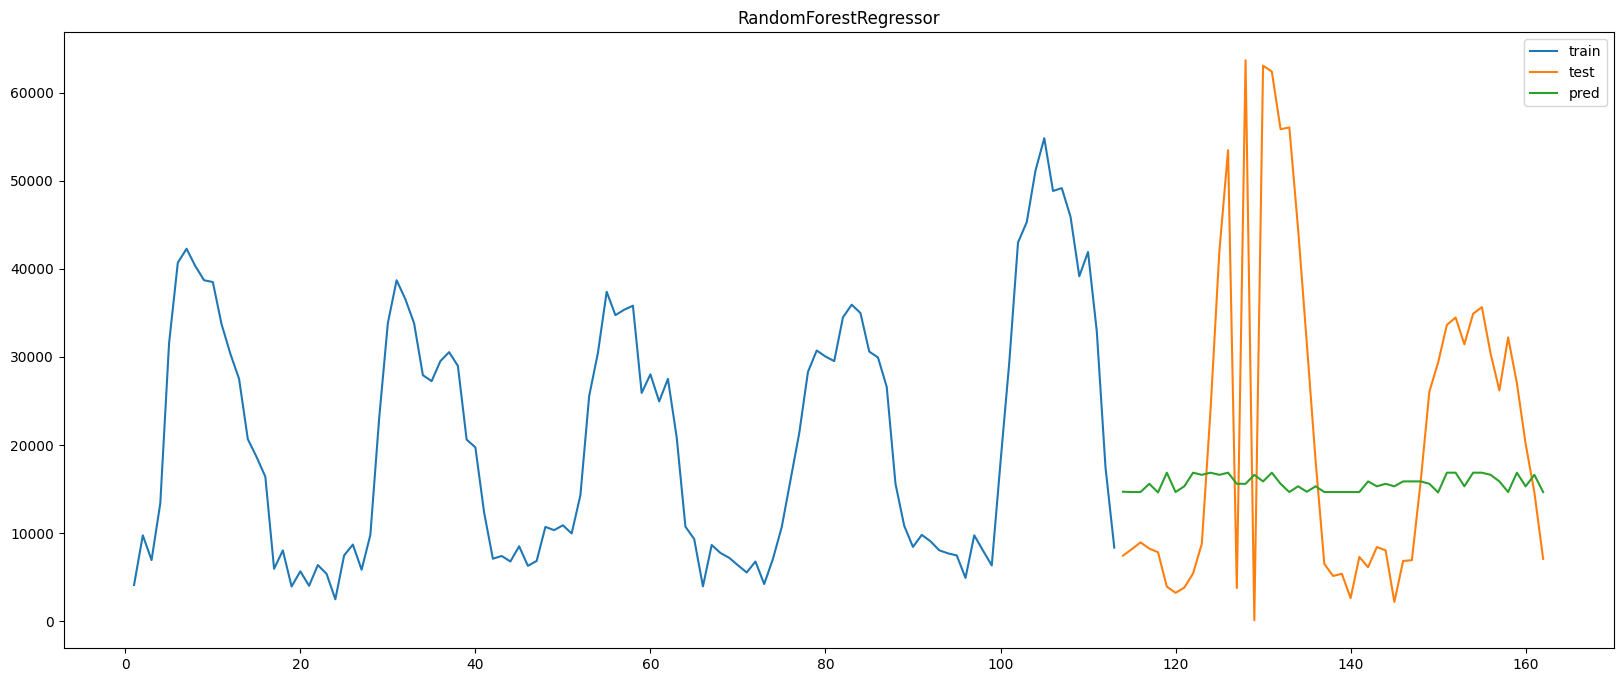

In [23]:
plt.figure(figsize=(20,8))        
plt.plot(range(1, len(y_train)+1), y_train, label='train')
plt.plot(range(len(y_train)+1, len(y_train)+len(y_test)+1), y_test, label='test')
plt.plot(range(len(y_train)+1, len(y_train)+len(y_test)+1), y_pred, label='pred')
plt.title("RandomForestRegressor")
plt.legend()
plt.show()

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

final_model = RandomForestRegressor(random_state=42, **best_params)
final_model.fit(X_train, y_train)

test_accuracy = final_model.score(X_test, y_test)
print("Validation Accuracy:", test_accuracy)

Validation Accuracy: -0.3995612370212993


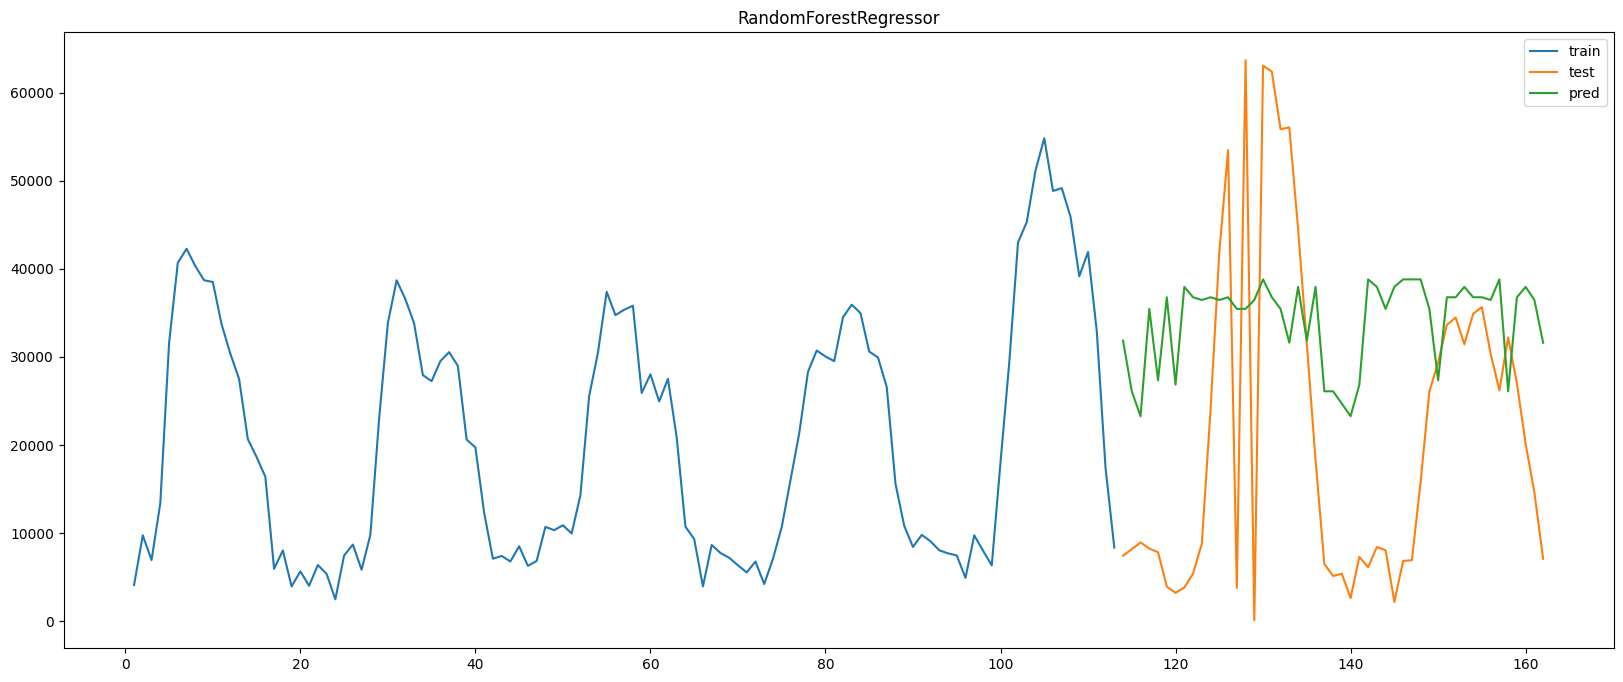

In [25]:
y_pred=final_model.predict(X_test)
plt.figure(figsize=(20,8))        
plt.plot(range(1, len(y_train)+1), y_train, label='train')
plt.plot(range(len(y_train)+1, len(y_train)+len(y_test)+1), y_test, label='test')
plt.plot(range(len(y_train)+1, len(y_train)+len(y_test)+1), y_pred, label='pred')
plt.title("RandomForestRegressor")
plt.legend()
plt.show()

RFR daje najlošije rezultate od bilo kojeg do sad isprobanog algoritma. On ne radi s periodima nego je samo regresor pa je to razlog rezultata.

# 6. Generated signal

In [26]:
from scipy import signal
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 200 * t) 
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63) 
trend = np.linspace(0, 600, 600)/(134*np.pi)
trend1 = np.linspace(0, 100, 100)/(104*np.pi)
trend2 = np.linspace(0, 300, 300)/(-122*np.pi)
trend3 = np.linspace(0, 200, 200)/(111*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

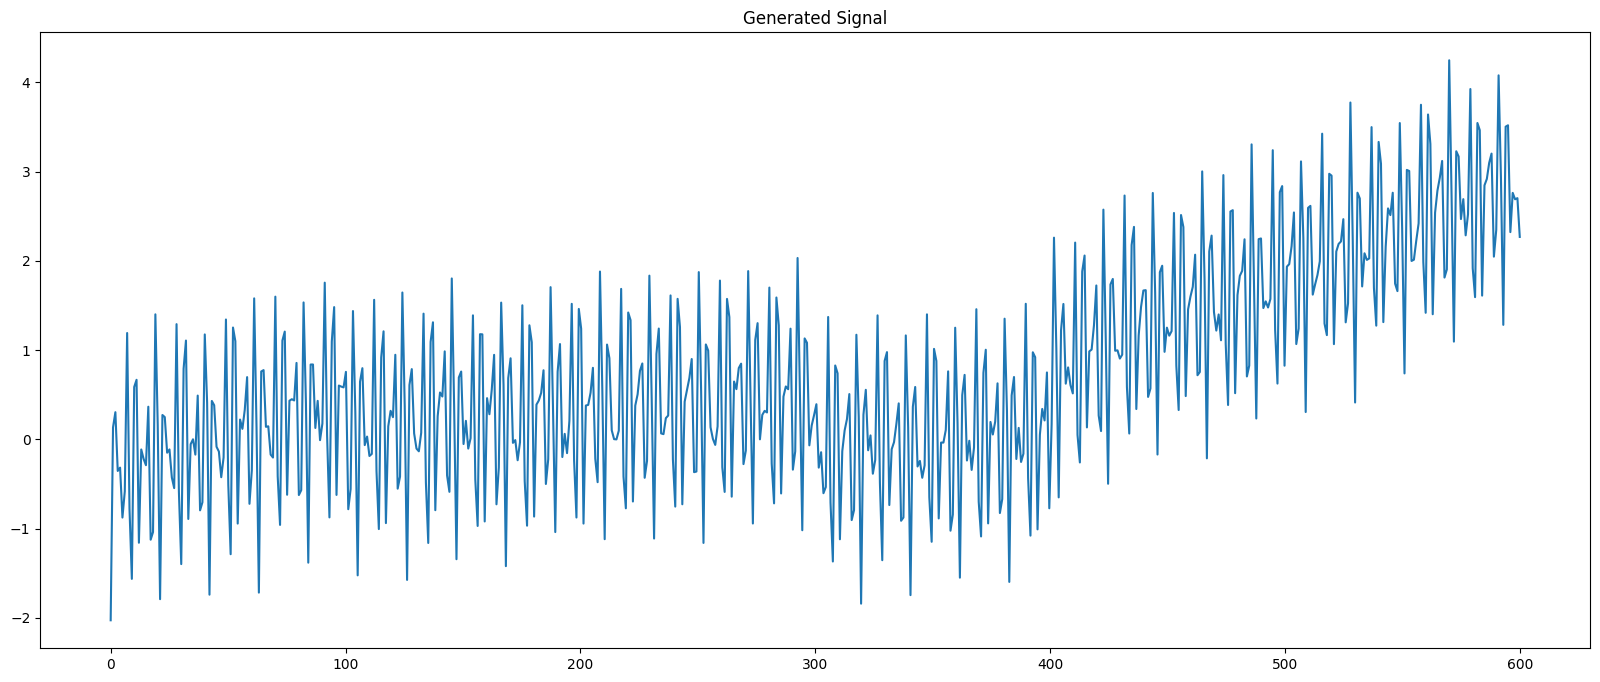

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(t, pts)
plt.title('Generated Signal')
plt.show()

Za detaljni prikaz perioda prikazat cu samo prvih 100 dana.

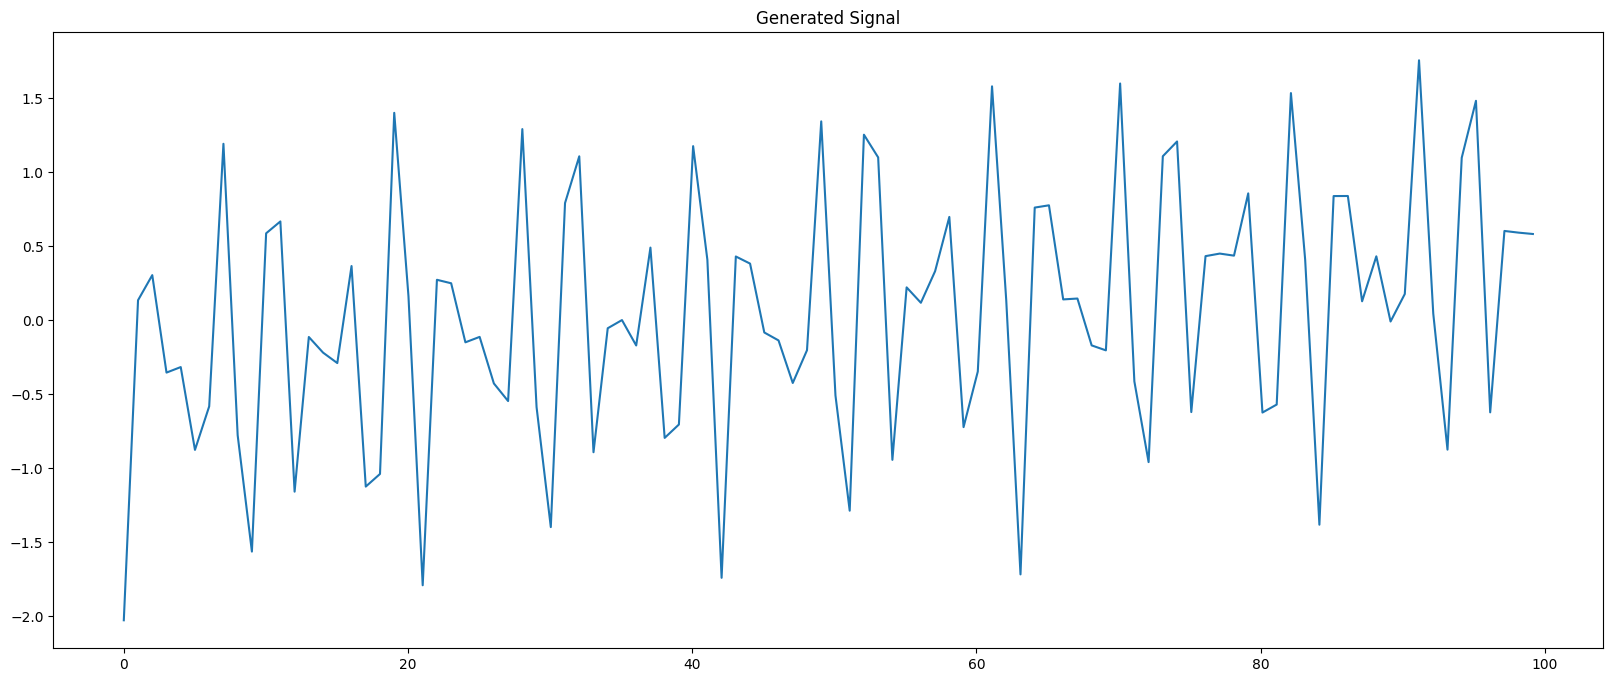

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(t[:100], pts[:100])
plt.title('Generated Signal')
plt.show()

Komponente signala su: triangle1 ,triangle2, trend, kombinacija(trend1, trend2, trend3) te noise.

pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

Signal ima ponavljajuće periode koji se javljaju otprilike svakih 5 do 6 dana.

Trend koji se vidi je rast prosječne vrijednosti period od 400-tog dana



Za izračun točnog broja perioda koristit ću korelaciju signala sa samim sobom.

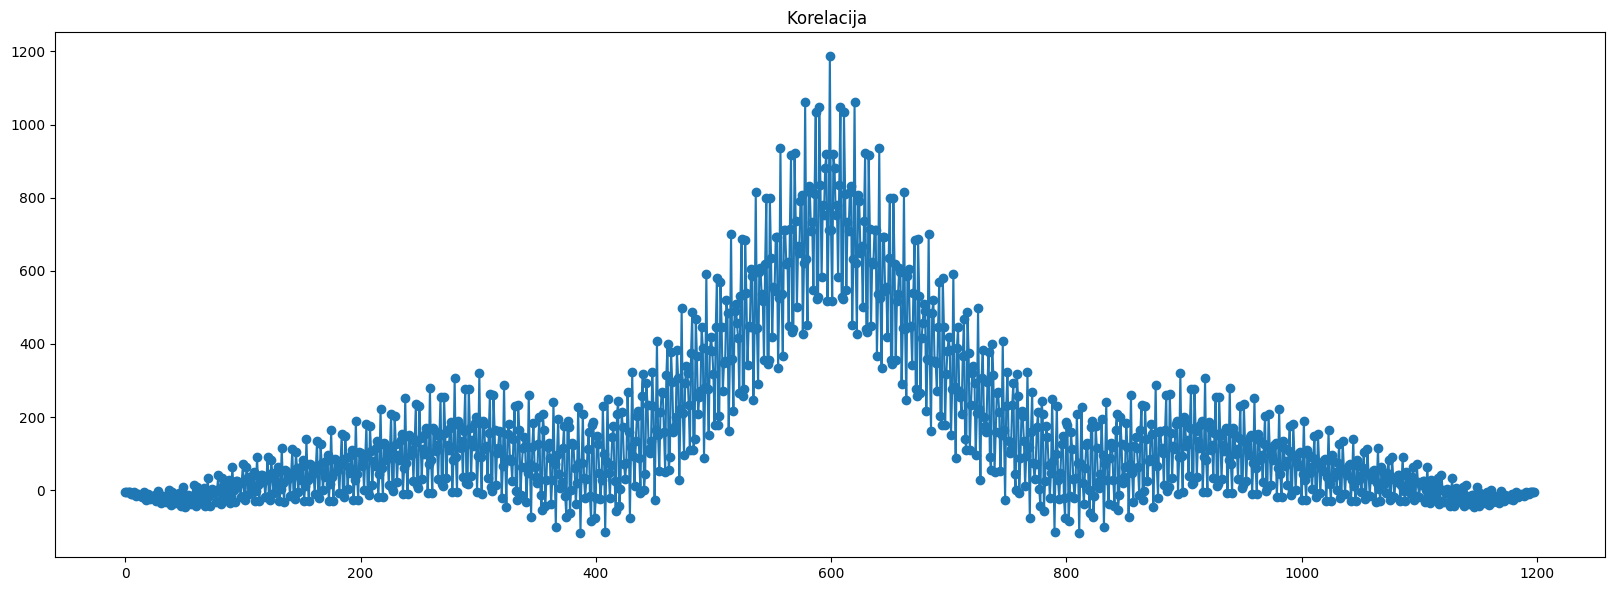

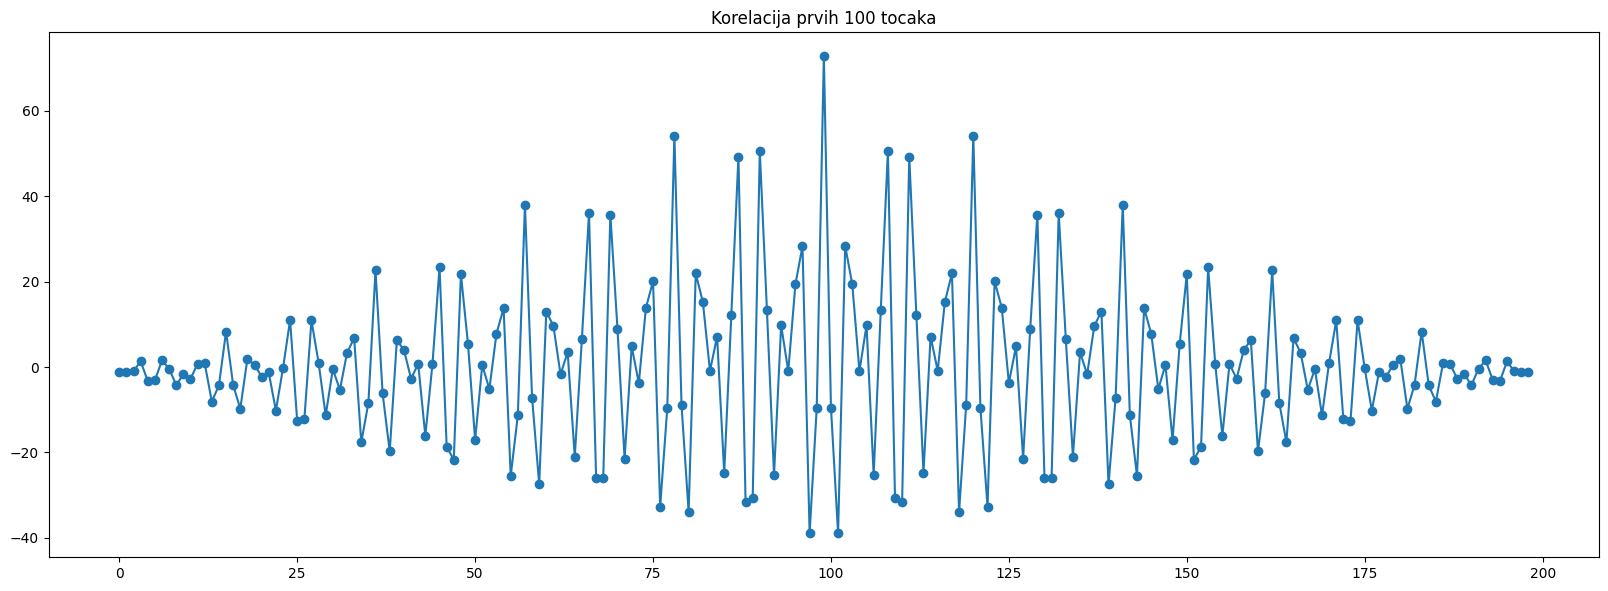

In [29]:
corr = np.correlate(pts, pts, mode='full')
corr_100 = np.correlate(pts[:100], pts[:100], mode='full')

plt.figure(figsize=(20, 15))
plt.subplot(2, 1, 1)
plt.scatter(range(0, len(corr)), corr)
plt.plot(range(0, len(corr)), corr)
plt.title('Korelacija ')

plt.figure(figsize=(20, 15))
plt.subplot(2, 1, 1)
plt.scatter(range(0, len(corr_100)), corr_100)
plt.plot(range(0, len(corr_100)), corr_100)
plt.title('Korelacija prvih 100 tocaka')

plt.show()

Sada ću sa find_peaks izračunati ukupan broj perioda i onda koliko se često isti pojavljuju.

In [30]:
peaks, properties = find_peaks(corr)
periods = np.diff(peaks) 
avg_period = np.mean(periods)

num_periods = len(pts) / avg_period
print("Broj perioda:"+ str(num_periods))
print("Trajanje perioda:", str(len(pts)/num_periods))

Broj perioda:177.8894472361809
Trajanje perioda: 3.3728813559322033


# 6.1 Exponential smoothing

In [31]:
model = ExponentialSmoothing(pts_train).fit()
pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)
rmse=mean_squared_error(pts_test, pred, squared=False)
mae=mean_absolute_error(pts_test, pred)

print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

RMSE: 1.0829616768552364
MAE: 0.8898356606537434


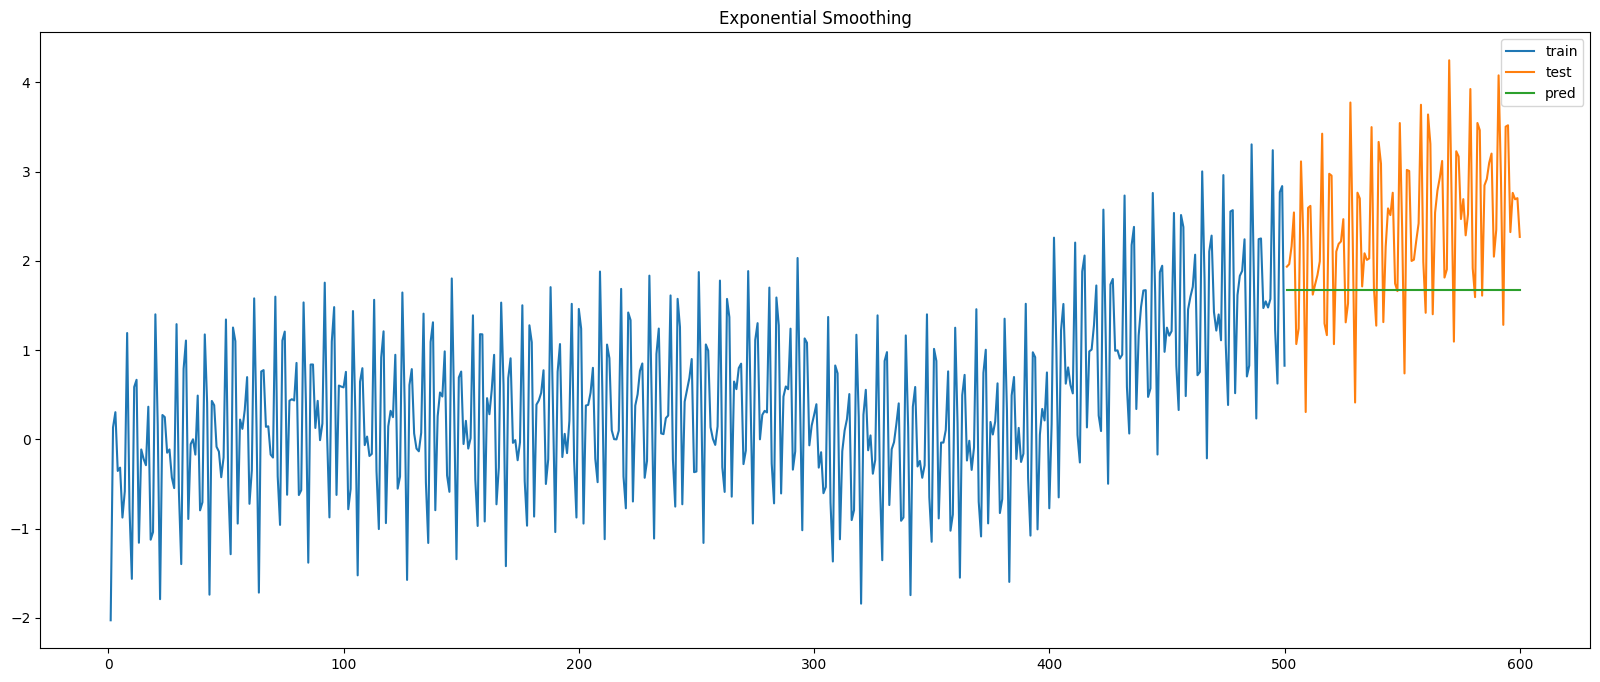

In [32]:
plt.figure(figsize=(20,8))
plt.plot(range(1, len(pts_train)+1), pts_train, label='train')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pts_test, label='test')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pred, label='pred')
plt.title('Exponential Smoothing')
plt.legend()
plt.show()

Sad je seasonal_periods=str(len(pts)/num_periods) samo zaokruženo do najbližeg cijelog broja.

Parametri:
Soothing_level: 0, Soothing_slope: 0, Soothing_seasonal: 0
RMSE: 2.143886180451757
MAE: 1.9811936701794357

Parametri:
Soothing_level: 0, Soothing_slope: 0, Soothing_seasonal: 0.1
RMSE: 1.0381329741148222
MAE: 0.8794435658742091

Parametri:
Soothing_level: 0, Soothing_slope: 0, Soothing_seasonal: 0.2
RMSE: 0.9061998592425095
MAE: 0.7488851005527066

Parametri:
Soothing_level: 0, Soothing_slope: 0, Soothing_seasonal: 0.5
RMSE: 0.8200476376689285
MAE: 0.6695364337404751

Parametri:
Soothing_level: 0, Soothing_slope: 0, Soothing_seasonal: 1
RMSE: 0.9633108154573673
MAE: 0.7833359929053656

Parametri:
Soothing_level: 0, Soothing_slope: 0.1, Soothing_seasonal: 0
RMSE: 2.143886180451757
MAE: 1.9811936701794357

Parametri:
Soothing_level: 0, Soothing_slope: 0.1, Soothing_seasonal: 0.1
RMSE: 1.0381329741148222
MAE: 0.8794435658742091

Parametri:
Soothing_level: 0, Soothing_slope: 0.1, Soothing_seasonal: 0.2
RMSE: 0.9061998592425095
MAE: 0.7488851005527066

Parametri:
Soothing_level:

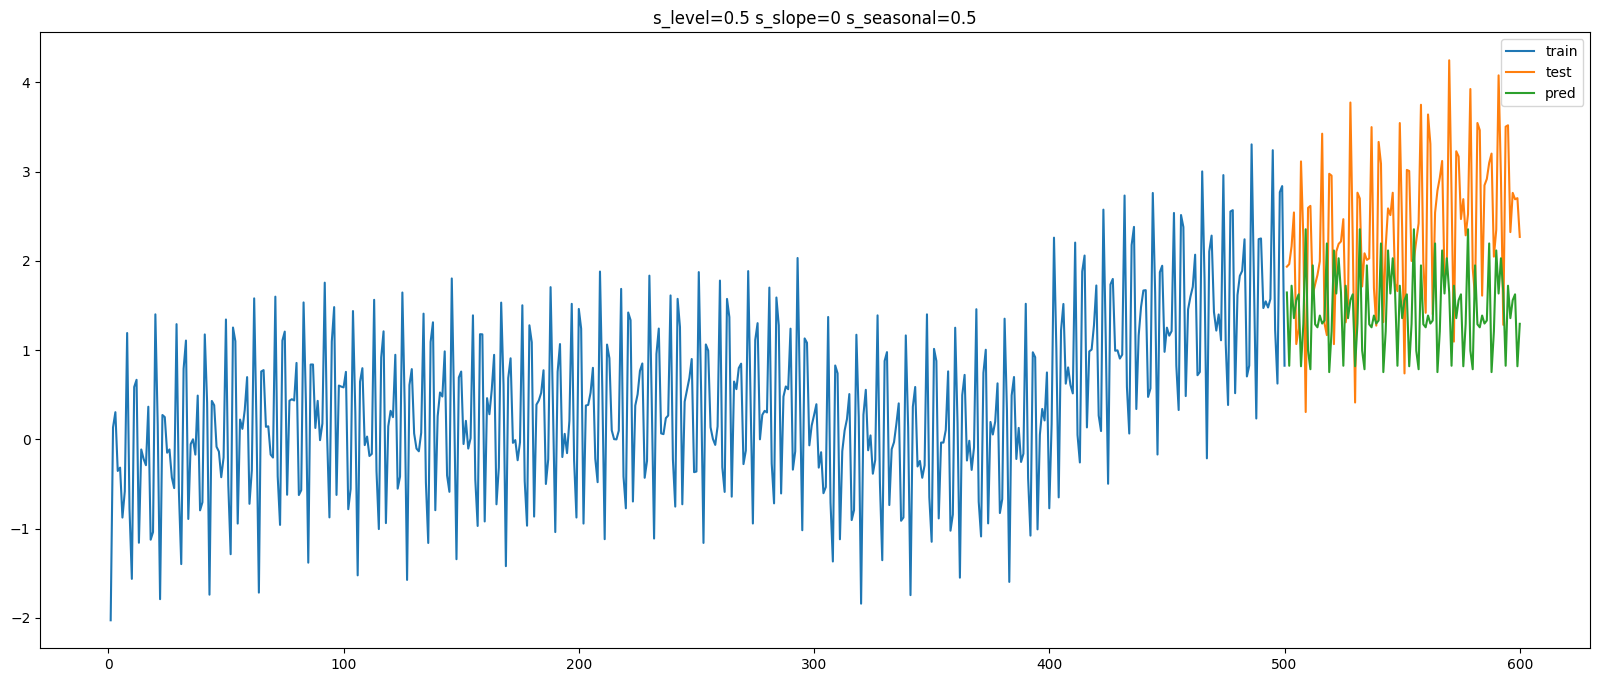

In [33]:
best_level=0
best_slope=0
best_seasonal=0
best_error=sys.maxsize
for smoothing_level in [0, 0.1, 0.2, 0.5, 1]:
    for smoothing_slope in [0, 0.1, 0.2, 0.5, 1]:
        for smoothing_seasonal in [0, 0.1, 0.2, 0.5, 1]:
            model = ExponentialSmoothing(pts_train, seasonal='add', seasonal_periods=int(len(pts)/num_periods)).fit(
                smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, smoothing_seasonal=smoothing_seasonal)

            pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)
            rmse=mean_squared_error(pts_test, pred, squared=False)
            mae=mean_absolute_error(pts_test, pred)
            
            print("Parametri:")
            print("Soothing_level: "+str(smoothing_level), end="")
            print(", Soothing_slope: "+str(smoothing_slope), end="")
            print(", Soothing_seasonal: "+str(smoothing_seasonal))
            print("RMSE: "+str(rmse))
            print("MAE: "+str(mae))
            print()
            
            
            if rmse < best_error:
                best_level=smoothing_level
                best_slope=smoothing_slope
                best_seasonal=smoothing_seasonal
                best_error=rmse

print()
print("Najbolji parametri:")
print("Soothing_level: "+str(best_level))
print("Soothing_slope: "+str(best_slope))
print("Soothing_seasonal: "+str(best_seasonal))

model = ExponentialSmoothing(pts_train, seasonal='add', seasonal_periods=23).fit(
                smoothing_level=best_level, smoothing_slope=best_slope, smoothing_seasonal=best_seasonal)
pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

rmse = np.sqrt(mean_squared_error(pts_test, pred))
mae = mean_absolute_error(pts_test, pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))
plt.plot(range(1, len(pts_train)+1), pts_train, label='train')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pts_test, label='test')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pred, label='pred')
plt.title('s_level='+str(best_level)+' s_slope='+str(best_slope)+' s_seasonal='+str(best_seasonal))
plt.legend()
plt.show()

Najbolje rezultate dobivam za parametre:
Soothing_level: 0.5,
Soothing_slope: 0,
Soothing_seasonal: 0.5.

# 6.2 ARIMA

RMSE: 2.1399890682549754
MAE: 1.9794596869029784


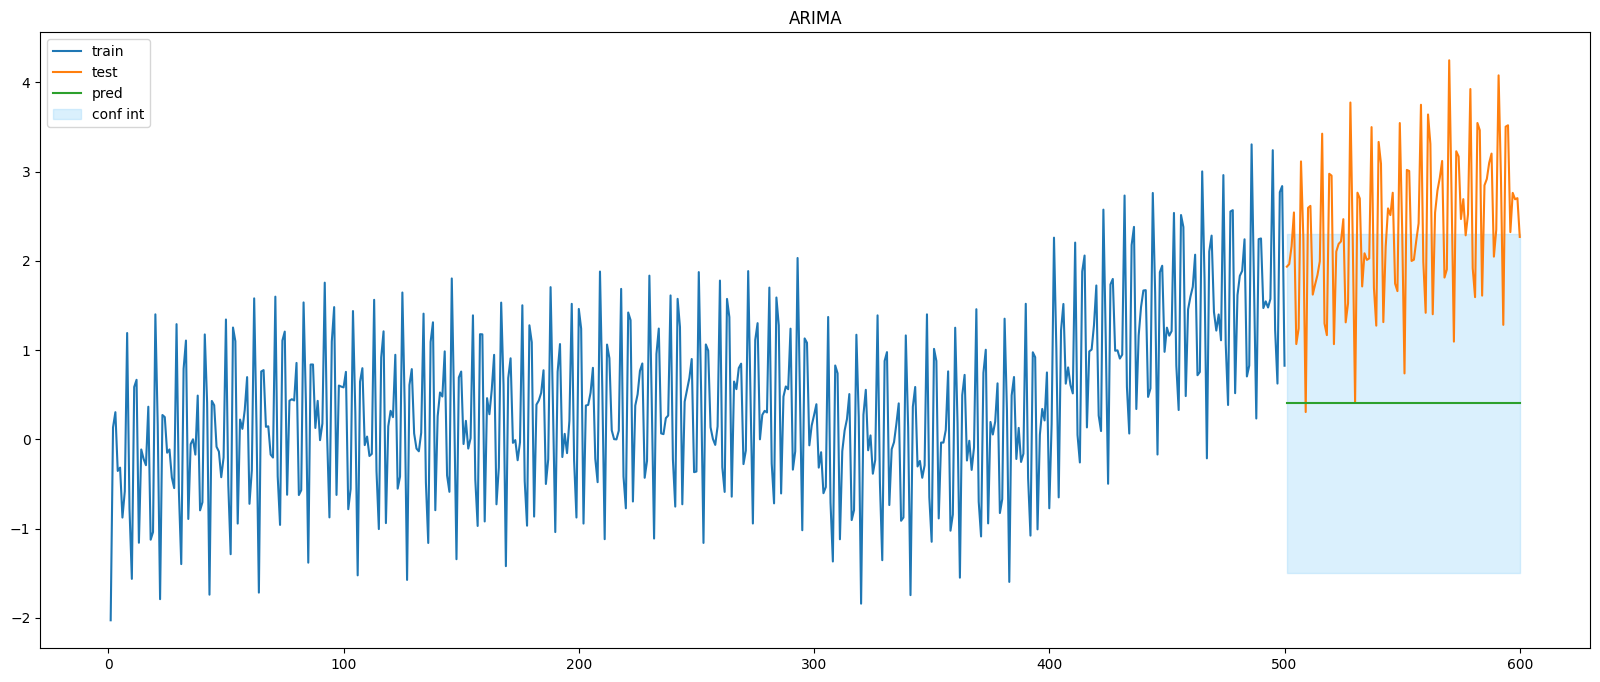

In [34]:
model = ARIMA(pts_train, order=(0, 0, 0)).fit()
pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

forecast = model.get_forecast(steps=len(pts_test))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse=mean_squared_error(pts_test, pred, squared=False)
mae=mean_absolute_error(pts_test, pred)

print("RMSE: "+str(rmse))
print("MAE: "+str(mae))


plt.figure(figsize=(20,8))        
plt.plot(range(1, len(pts_train)+1), pts_train, label='train')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pts_test, label='test')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pred, label='pred')
plt.fill_between(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA")
plt.legend()
plt.show()

P: 5
RMSE: 1.2726729025898174
MAE: 1.0411032029993958

P: 6
RMSE: 0.8945342837214733
MAE: 0.6943858865350292

P: 7
RMSE: 0.9073224630689999
MAE: 0.7459050869632599

P: 8
RMSE: 0.9268919393117304
MAE: 0.762586413201407

P: 9
RMSE: 0.7413650126884505
MAE: 0.6233719778719933

P: 10
RMSE: 0.7820060375394021
MAE: 0.6597563954820626

P: 11
RMSE: 0.7775122057817957
MAE: 0.6530563962534055

P: 12
RMSE: 0.601852855090896
MAE: 0.4994928718452538

P: 13
RMSE: 0.7601903458413121
MAE: 0.6299221663797574

P: 14
RMSE: 0.7524710847081039
MAE: 0.6269693919079833


Najbolji parametri:
P: 12
RMSE: 0.601852855090896
MAE: 0.4994928718452538


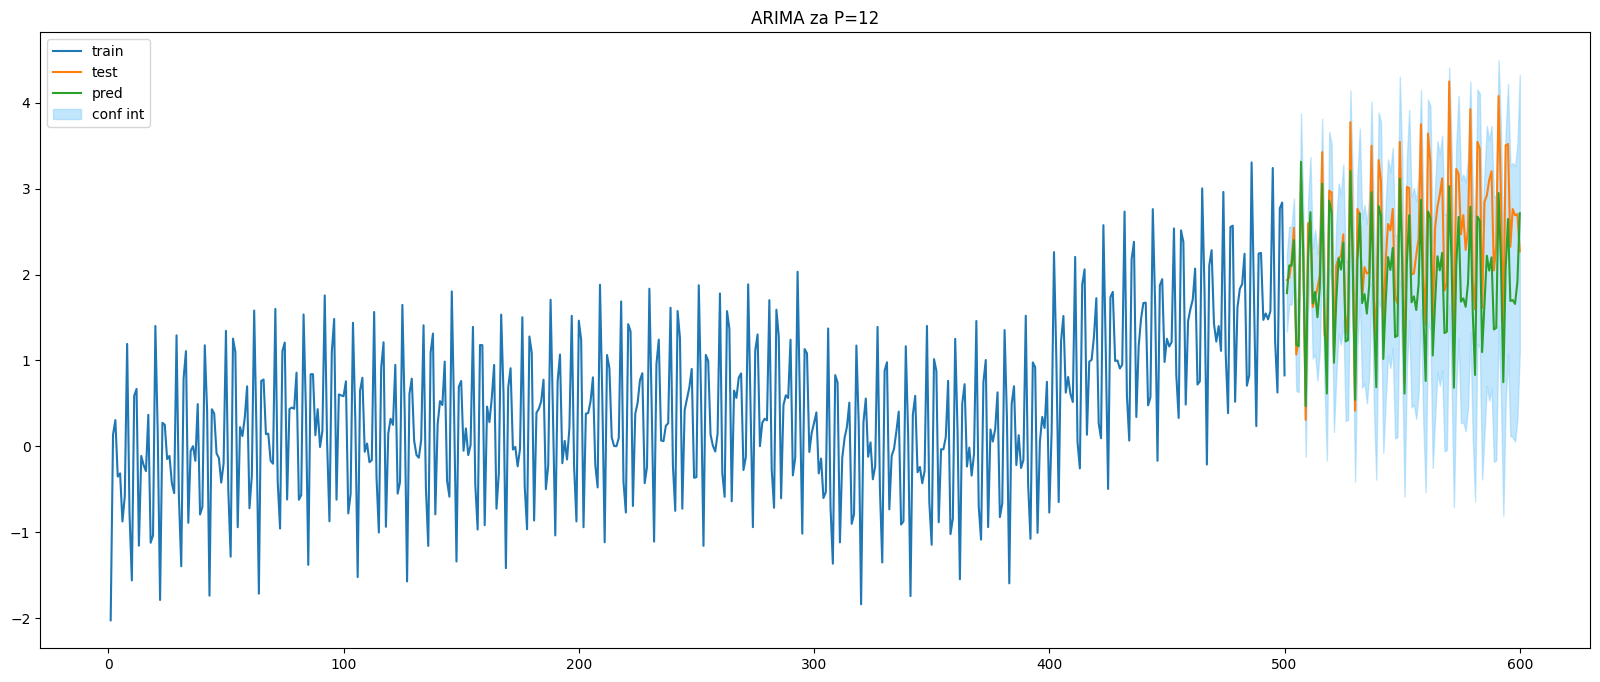

In [35]:
best_p=0
best_error=sys.maxsize
for p in range(5,15):
    model = ARIMA(pts_train, order=(p, 0, 0)).fit()
    pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

    rmse=mean_squared_error(pts_test, pred, squared=False)
    mae=mean_absolute_error(pts_test, pred)

    print("P: "+str(p))
    print("RMSE: "+str(rmse))
    print("MAE: "+str(mae))
    print()
                
    if rmse < best_error:
        best_p=p
        best_error=rmse

print()
print("Najbolji parametri:")
print("P: "+str(best_p))

model = ARIMA(pts_train, order=(best_p, 0, 0)).fit()
pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

forecast = model.get_forecast(steps=len(pts_test))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse = np.sqrt(mean_squared_error(pts_test, pred))
mae = mean_absolute_error(pts_test,pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(pts_train)+1), pts_train, label='train')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pts_test, label='test')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pred, label='pred')
plt.fill_between(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.5, label='conf int')
plt.title("ARIMA za P="+str(best_p))
plt.legend()
plt.show()

Najbolji p je 12.

Q: 0
RMSE: 2.1399890682549754
MAE: 1.9794596869029784

Q: 5
RMSE: 2.121858012029825
MAE: 1.9514782362495608

Q: 10
RMSE: 2.1030861629270237
MAE: 1.9281698138413463

Q: 15
RMSE: 2.0666868988327587
MAE: 1.8663567110392487

Q: 20
RMSE: 2.054025010165318
MAE: 1.8500935819493562

Q: 25
RMSE: 2.0181825550234374
MAE: 1.7983077089444996

Q: 30
RMSE: 1.9999473283354123
MAE: 1.7751669750986718

Q: 35
RMSE: 1.9581659112443952
MAE: 1.7155863503138753

Q: 40
RMSE: 1.9432045104475089
MAE: 1.6974606643653949

Q: 45
RMSE: 1.9178514219782556
MAE: 1.6659609444218773

Q: 50
RMSE: 1.9016839639133234
MAE: 1.639965017496923


Najbolji parametri:
Q: 50
RMSE: 1.9016839639133234
MAE: 1.639965017496923


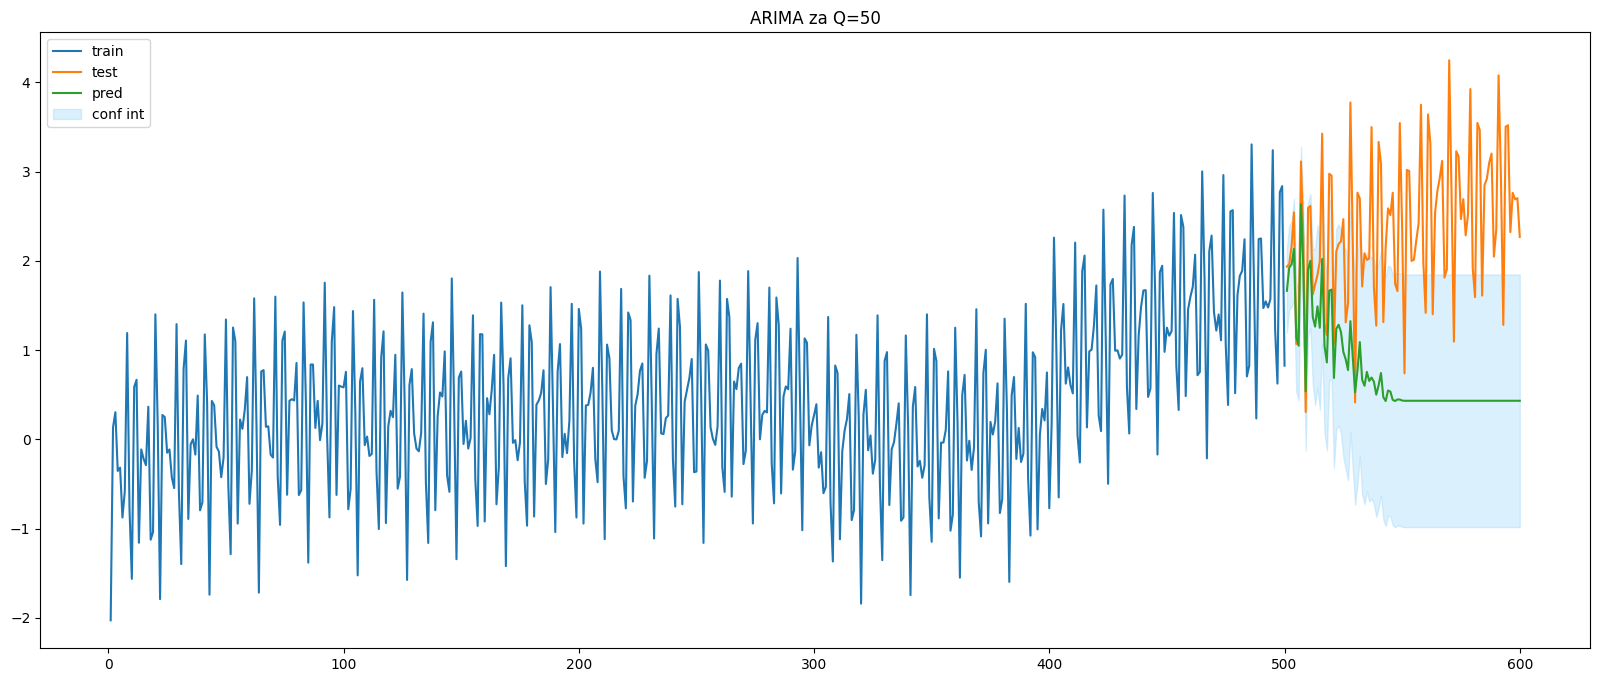

In [36]:
best_q=0
best_error=sys.maxsize
for q in [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    model = ARIMA(pts_train, order=(0, 0, q)).fit()
    pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

    rmse=mean_squared_error(pts_test, pred, squared=False)
    mae=mean_absolute_error(pts_test, pred)

    print("Q: "+str(q))
    print("RMSE: "+str(rmse))
    print("MAE: "+str(mae))
    print()
                
    if rmse < best_error:
        best_q=q
        best_error=rmse

print()
print("Najbolji parametri:")
print("Q: "+str(best_q))

model = ARIMA(pts_train, order=(0, 0,best_q)).fit()
pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

forecast = model.get_forecast(steps=len(pts_test))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse = np.sqrt(mean_squared_error(pts_test, pred))
mae = mean_absolute_error(pts_test,pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(pts_train)+1), pts_train, label='train')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pts_test, label='test')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pred, label='pred')
plt.fill_between(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA za Q="+str(best_q))
plt.legend()
plt.show()

Najbolji q je 50.

D: 0
RMSE: 2.1399890682549754
MAE: 1.9794596869029784

D: 1
RMSE: 1.7569878574742825
MAE: 1.5753708097778523

D: 2
RMSE: 118.5781079773322
MAE: 103.20562210567562

D: 3
RMSE: 4885.37955613377
MAE: 3676.5927308381615

D: 4
RMSE: 5195.375126270951
MAE: 3886.004625288622

D: 5
RMSE: 7310504.04408347
MAE: 4428966.637977097

D: 6
RMSE: 323223842.18825805
MAE: 181239071.785082

D: 7
RMSE: 6573189857.695136
MAE: 3448821809.8861933

D: 8
RMSE: 18144658333.281998
MAE: 9153266993.841589

D: 9
RMSE: 3412966442731.209
MAE: 1593735582019.7566


Najbolji parametri:
D: 1
RMSE: 1.7569878574742825
MAE: 1.5753708097778523


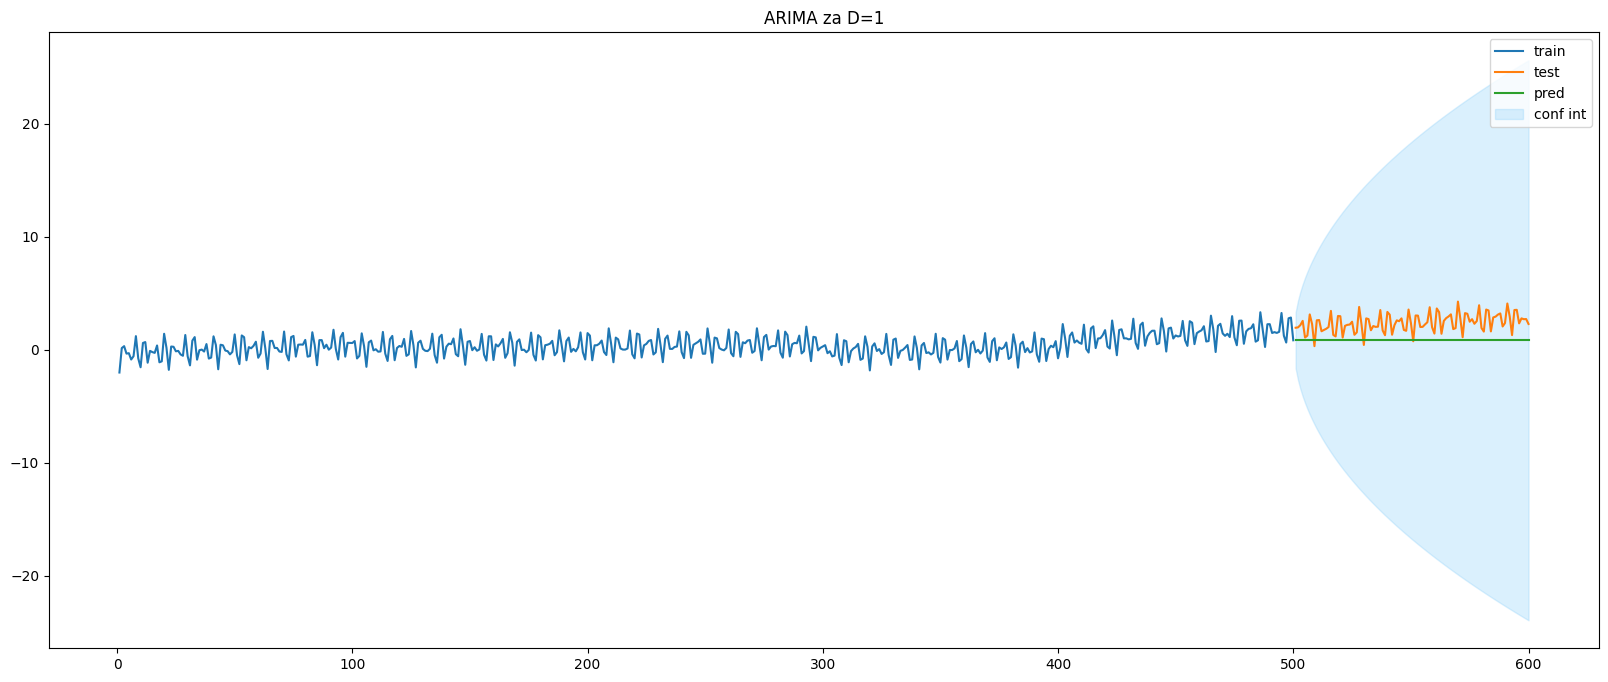

In [37]:
best_d=0
best_error=sys.maxsize
for d in range(10):
    model = ARIMA(pts_train, order=(0, d, 0)).fit()
    pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

    rmse=mean_squared_error(pts_test, pred, squared=False)
    mae=mean_absolute_error(pts_test, pred)

    print("D: "+str(d))
    print("RMSE: "+str(rmse))
    print("MAE: "+str(mae))
    print()
                
    if rmse < best_error:
        best_d=d
        best_error=rmse

print()
print("Najbolji parametri:")
print("D: "+str(best_d))

model = ARIMA(pts_train, order=(0, best_d, 0)).fit()
pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

forecast = model.get_forecast(steps=len(pts_test))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse = np.sqrt(mean_squared_error(pts_test, pred))
mae = mean_absolute_error(pts_test,pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(pts_train)+1), pts_train, label='train')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pts_test, label='test')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pred, label='pred')
plt.fill_between(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA za D="+str(best_d))
plt.legend()
plt.show()

Parametri:
P: 8, D: 0, Q: 5
RMSE: 1.225147221288871
MAE: 1.039799136209444

Parametri:
P: 8, D: 0, Q: 10
RMSE: 0.6924951700245026
MAE: 0.5916716850859465

Parametri:
P: 8, D: 0, Q: 15
RMSE: 0.8508779911470205
MAE: 0.6692920963944076

Parametri:
P: 8, D: 1, Q: 5
RMSE: 0.6333115853480396
MAE: 0.5288550322468607

Parametri:
P: 8, D: 1, Q: 10
RMSE: 0.6074586794926828
MAE: 0.5179312005750673

Parametri:
P: 8, D: 1, Q: 15
RMSE: 0.6199615988059223
MAE: 0.5260888776830551

Parametri:
P: 8, D: 2, Q: 5
RMSE: 0.34818568472280575
MAE: 0.2719820911343572

Parametri:
P: 8, D: 2, Q: 10
RMSE: 0.35121106054298323
MAE: 0.26880729730821507

Parametri:
P: 8, D: 2, Q: 15
RMSE: 0.6358118315123278
MAE: 0.5221716808669788

Parametri:
P: 10, D: 0, Q: 5
RMSE: 0.7511495302694692
MAE: 0.6210597255548653

Parametri:
P: 10, D: 0, Q: 10
RMSE: 0.6756580680885717
MAE: 0.5726778440942104

Parametri:
P: 10, D: 0, Q: 15
RMSE: 0.8896157816653336
MAE: 0.758502096293314

Parametri:
P: 10, D: 1, Q: 5
RMSE: 0.6154873373163441

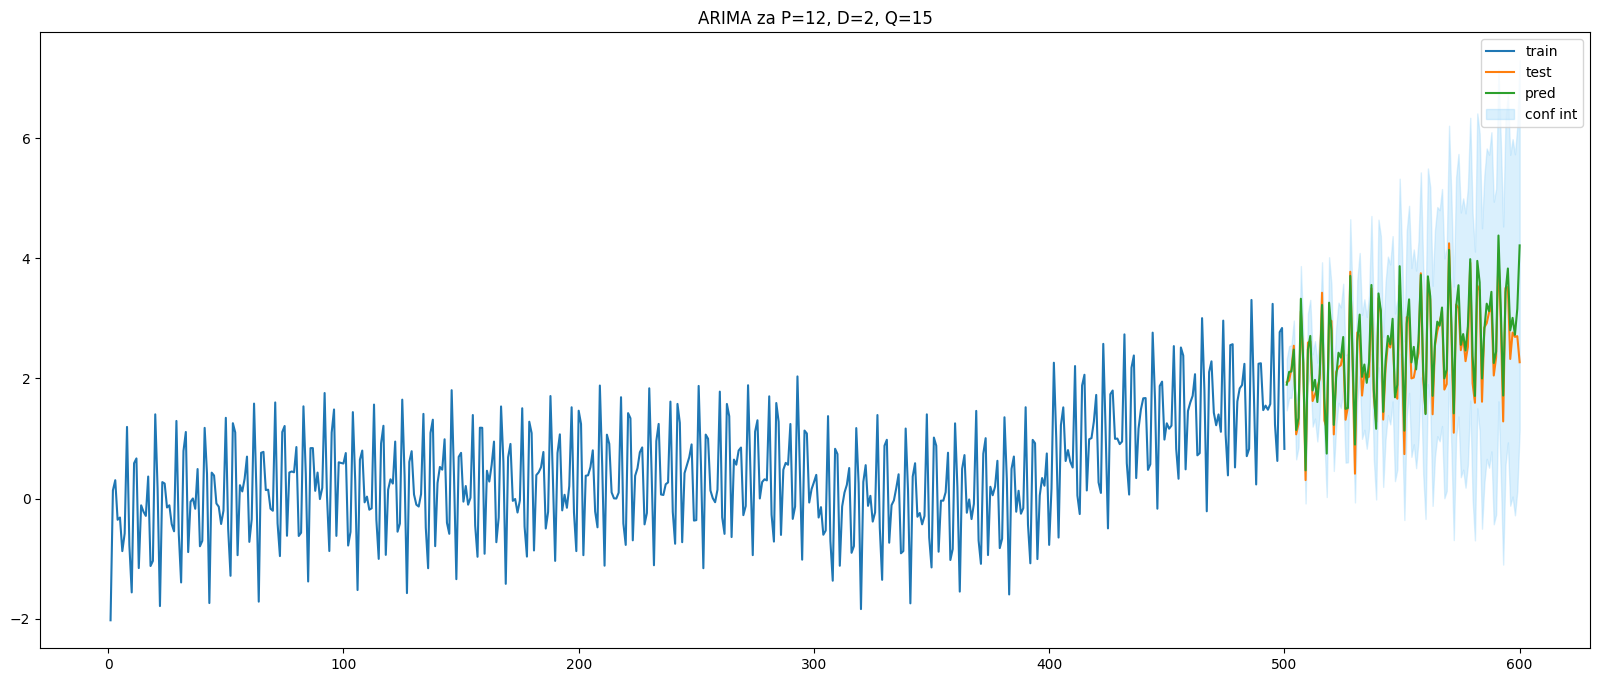

In [38]:
best_p=0
best_d=0
best_q=0
best_error=sys.maxsize

for p in [8, 10, 12]:
    for d in range(3):
        for q in [5,10,15]:
            model = ARIMA(pts_train, order=(p, d, q)).fit()
            pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

            rmse=mean_squared_error(pts_test, pred, squared=False)
            mae=mean_absolute_error(pts_test, pred)
            
            print("Parametri:")
            print("P: "+str(p), end="")
            print(", D: "+str(d), end="")
            print(", Q: "+str(q))
            
            print("RMSE: "+str(rmse))
            print("MAE: "+str(mae))
            print()

            if rmse < best_error:
                best_p=p
                best_d=d
                best_q=q
                best_error=rmse

print("Najbolji parametri:")
print("P: "+str(best_p))
print("D: "+str(best_d))
print("Q: "+str(best_q))

model = ARIMA(pts_train, order=(best_p, best_d, best_q)).fit()
pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

forecast = model.get_forecast(steps=len(pts_test))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse = np.sqrt(mean_squared_error(pts_test, pred))
mae = mean_absolute_error(pts_test,pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(pts_train)+1), pts_train, label='train')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pts_test, label='test')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pred, label='pred')
plt.fill_between(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA za P="+str(best_p)+", D="+str(best_d)+", Q="+str(best_q))
plt.legend()
plt.show()

Najbolja je kombinacija (12, 2, 15)

S: 2
RMSE: 0.41539368510890823
MAE: 0.32446548166881056

S: 3
RMSE: 0.23564490419936387
MAE: 0.1393040611901553

S: 4
RMSE: 0.4770386725442979
MAE: 0.38716023379594544

S: 5
RMSE: 0.43802678226699326
MAE: 0.3431285037444793

S: 6
RMSE: 0.4321111707944391
MAE: 0.340684278429268

S: 7
RMSE: 0.6076703499092636
MAE: 0.5409170499532505

S: 8
RMSE: 0.48048068435833274
MAE: 0.3832607064766866

S: 9
RMSE: 0.6107528119323196
MAE: 0.5192547489850096


Najbolji parametri:
S: 3
RMSE: 0.6107528119323196
MAE: 0.5192547489850096


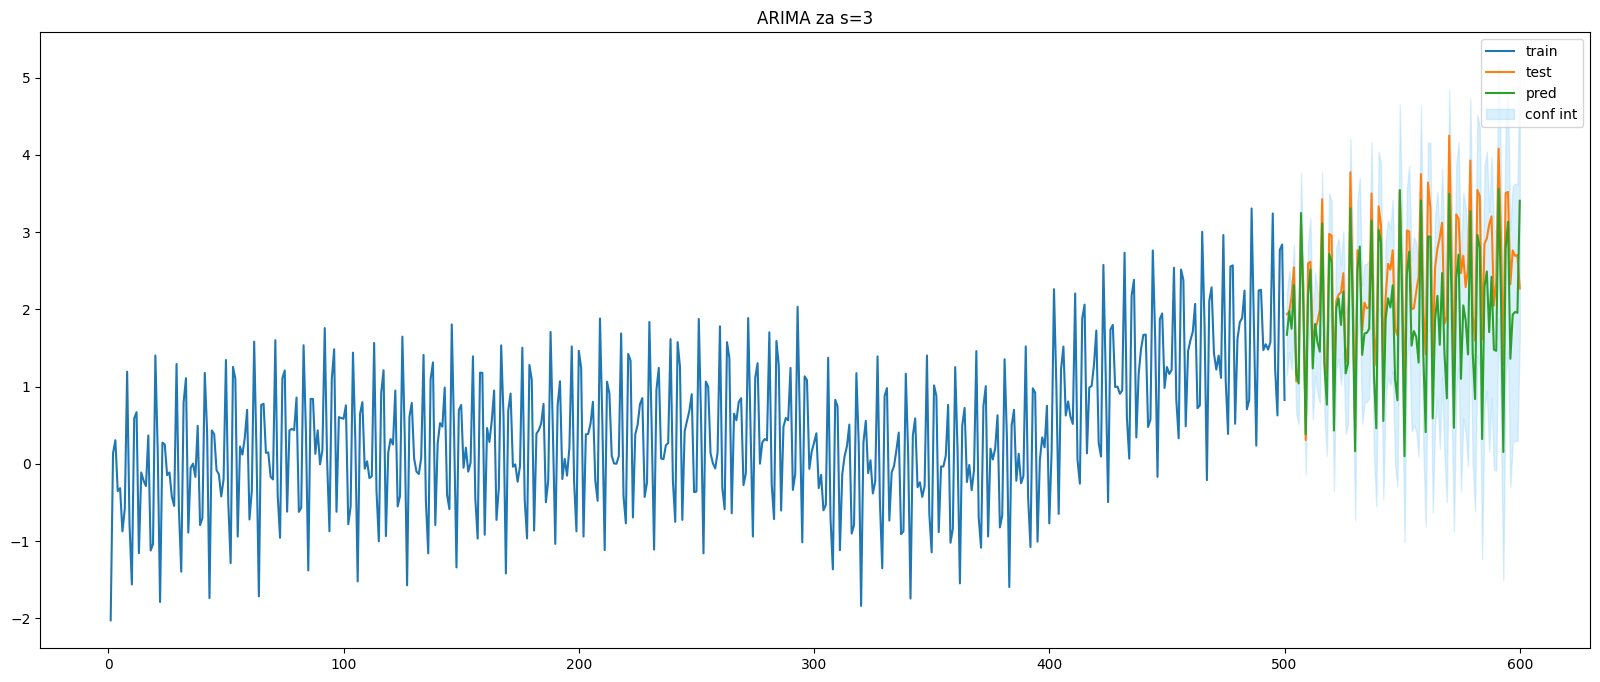

In [39]:
best_s=0
best_error=sys.maxsize
for s in range(2, 10):
    model = ARIMA(pts_train, order=(0, 0, 0), seasonal_order=(12,2,15,s)).fit()
    pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

    rmse=mean_squared_error(pts_test, pred, squared=False)
    mae=mean_absolute_error(pts_test, pred)

    print("S: "+str(s))
    print("RMSE: "+str(rmse))
    print("MAE: "+str(mae))
    print()
                
    if rmse < best_error:
        best_s=s
        best_error=rmse

print()
print("Najbolji parametri:")
print("S: "+str(best_s))

model = ARIMA(pts_train, order=(0, 0, 0), seasonal_order=(12,2,15,s)).fit()
pred = model.predict(start=len(pts_train), end=len(pts_train) + len(pts_test) - 1)

forecast = model.get_forecast(steps=len(pts_test))
conf_int = np.asarray(forecast.conf_int(alpha=0.05))

rmse = np.sqrt(mean_squared_error(pts_test, pred))
mae = mean_absolute_error(pts_test,pred)
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

plt.figure(figsize=(20,8))        
plt.plot(range(1, len(pts_train)+1), pts_train, label='train')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pts_test, label='test')
plt.plot(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), pred, label='pred')
plt.fill_between(range(len(pts_train)+1, len(pts_train)+len(pts_test)+1), conf_int[:, 0], conf_int[:, 1], color='lightskyblue', alpha=0.3, label='conf int')
plt.title("ARIMA za s="+str(best_s))
plt.legend()
plt.show()

# 6.3 Facebook Prophet

In [40]:
start_date = '2018-06-15'
desired_length = len(pts)  # Specify the desired length of the date_list

dates = pd.date_range(start=start_date, periods=desired_length).strftime('%Y-%m-%d').tolist()
pts_dict = {'ds': dates, 'y': pts}
pts_df = pd.DataFrame(pts_dict)
pts_df['ds'] = pd.to_datetime(pts_df['ds'])

pts_train_data = pts_df[:-(last_n_rows-n_train_rows)]
pts_test_data = pts_df[-(last_n_rows-n_train_rows):]

15:31:31 - cmdstanpy - INFO - Chain [1] start processing
15:31:31 - cmdstanpy - INFO - Chain [1] done processing


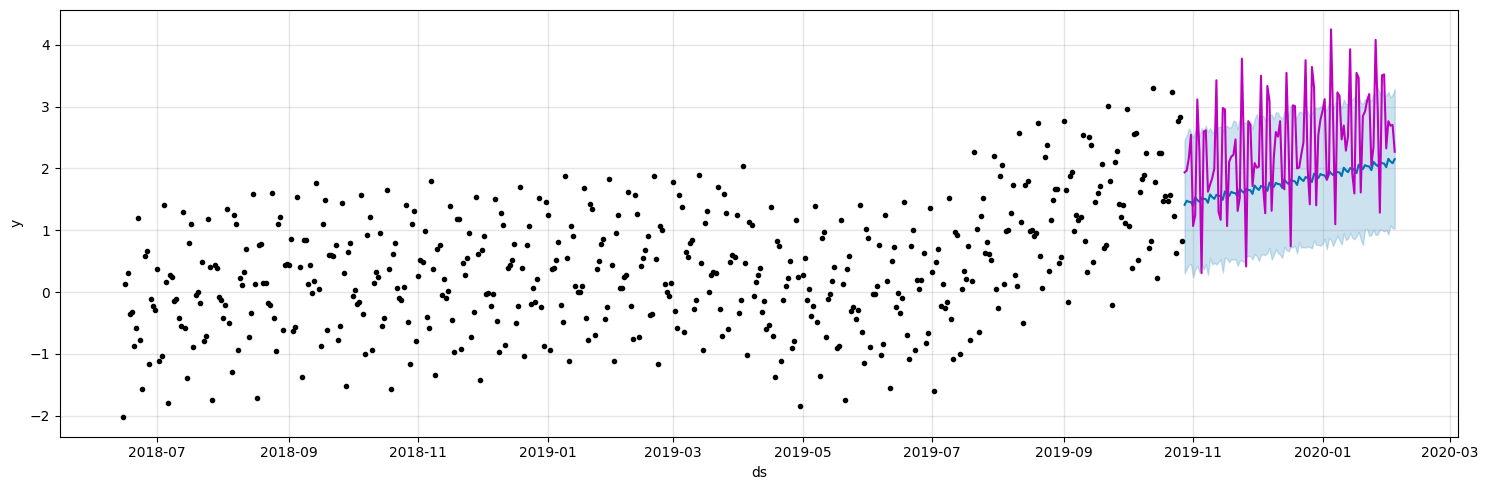

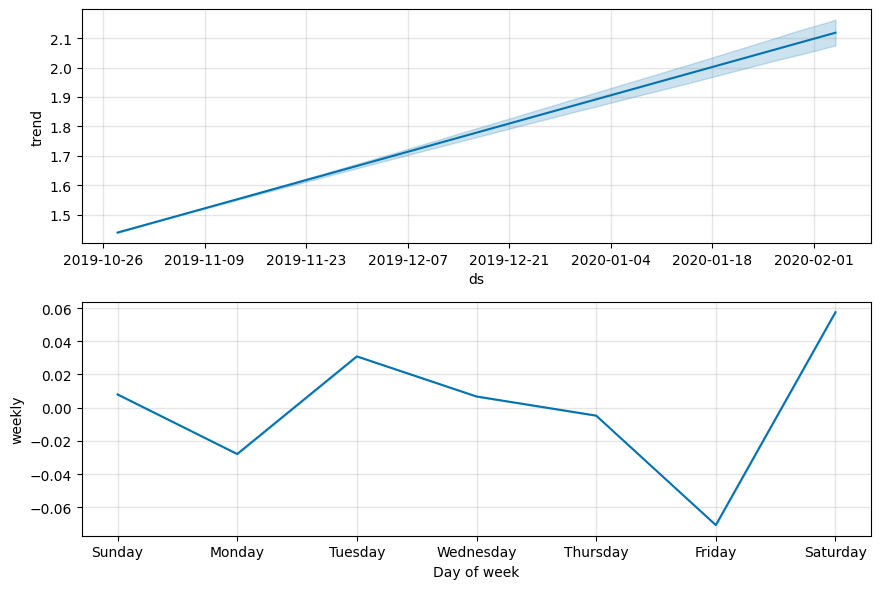

In [41]:
model = Prophet()
model.fit(pts_train_data)
pred = model.predict(df=pts_test_data)

figure, ax = plt.subplots(1)
figure.set_figheight(5)
figure.set_figwidth(15)
fig=model.plot(pred,ax=ax)
ax.plot(pts_test_data.ds, pts_test_data['y'], color='m')
plt.show()
fig = model.plot_components(pred)

In [42]:
y_pred = pred['yhat']
y_true = pts_test_data['y'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

RMSE: 0.98029179042033
MAE: 0.8062799153711512


15:31:32 - cmdstanpy - INFO - Chain [1] start processing
15:31:32 - cmdstanpy - INFO - Chain [1] done processing
15:31:33 - cmdstanpy - INFO - Chain [1] start processing
15:31:33 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 6
Fourier order big: 17
RMSE: 0.9645274671881318
MAE: 0.8090278623435604



15:31:33 - cmdstanpy - INFO - Chain [1] start processing
15:31:34 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 6
Fourier order big: 19
RMSE: 0.9399139900537136
MAE: 0.7847751233998327



15:31:34 - cmdstanpy - INFO - Chain [1] start processing
15:31:34 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 6
Fourier order big: 21
RMSE: 1.038354518931633
MAE: 0.8785307357046226



15:31:35 - cmdstanpy - INFO - Chain [1] start processing
15:31:35 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 6
Fourier order big: 23
RMSE: 0.9592145190867093
MAE: 0.8037932363596696



15:31:35 - cmdstanpy - INFO - Chain [1] start processing
15:31:35 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 6
Fourier order big: 25
RMSE: 0.9470067093641024
MAE: 0.791779847901469



15:31:36 - cmdstanpy - INFO - Chain [1] start processing
15:31:36 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 8
Fourier order big: 17
RMSE: 0.9507465064324668
MAE: 0.7954854045301525



15:31:36 - cmdstanpy - INFO - Chain [1] start processing
15:31:36 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 8
Fourier order big: 19
RMSE: 0.9366453612570468
MAE: 0.781632316315244



15:31:37 - cmdstanpy - INFO - Chain [1] start processing
15:31:37 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 8
Fourier order big: 21
RMSE: 0.9460159738437025
MAE: 0.7908752812124666



15:31:37 - cmdstanpy - INFO - Chain [1] start processing
15:31:37 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 8
Fourier order big: 23
RMSE: 0.9518319251362185
MAE: 0.7964617083761764



15:31:38 - cmdstanpy - INFO - Chain [1] start processing
15:31:38 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 8
Fourier order big: 25
RMSE: 0.9308031905684158
MAE: 0.7760498401353965



15:31:38 - cmdstanpy - INFO - Chain [1] start processing
15:31:38 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 10
Fourier order big: 17
RMSE: 0.9206564986334973
MAE: 0.7664260845710231



15:31:39 - cmdstanpy - INFO - Chain [1] start processing
15:31:39 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 10
Fourier order big: 19
RMSE: 0.9465044295460893
MAE: 0.7911853772562126



15:31:40 - cmdstanpy - INFO - Chain [1] start processing
15:31:40 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 10
Fourier order big: 21
RMSE: 0.9261694739098373
MAE: 0.7716617100932379



15:31:40 - cmdstanpy - INFO - Chain [1] start processing
15:31:40 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 10
Fourier order big: 23
RMSE: 0.9423901529926243
MAE: 0.787203339270388



15:31:41 - cmdstanpy - INFO - Chain [1] start processing
15:31:41 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 10
Fourier order big: 25
RMSE: 0.9249842684437359
MAE: 0.7704721643561855



15:31:41 - cmdstanpy - INFO - Chain [1] start processing
15:31:41 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 12
Fourier order big: 17
RMSE: 0.9489362179954036
MAE: 0.7936625165862345



15:31:42 - cmdstanpy - INFO - Chain [1] start processing
15:31:42 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 12
Fourier order big: 19
RMSE: 0.9872949046336341
MAE: 0.8313292233351177



15:31:42 - cmdstanpy - INFO - Chain [1] start processing
15:31:42 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 12
Fourier order big: 21
RMSE: 0.9779335411377418
MAE: 0.8221673862101665



15:31:43 - cmdstanpy - INFO - Chain [1] start processing
15:31:43 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 12
Fourier order big: 23
RMSE: 0.8996786838444933
MAE: 0.7463365573579136



15:31:44 - cmdstanpy - INFO - Chain [1] start processing
15:31:44 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 12
Fourier order big: 25
RMSE: 0.9118153740690789
MAE: 0.7580381810393629



15:31:44 - cmdstanpy - INFO - Chain [1] start processing
15:31:44 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 14
Fourier order big: 17
RMSE: 0.9806910712006626
MAE: 0.8247822769435743



15:31:45 - cmdstanpy - INFO - Chain [1] start processing
15:31:45 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 14
Fourier order big: 19
RMSE: 0.9300633318540229
MAE: 0.7754534859058902



15:31:45 - cmdstanpy - INFO - Chain [1] start processing
15:31:45 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 14
Fourier order big: 21
RMSE: 0.929287059131904
MAE: 0.7745119000997329



15:31:46 - cmdstanpy - INFO - Chain [1] start processing
15:31:46 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 14
Fourier order big: 23
RMSE: 0.9149311698562081
MAE: 0.7610192295624083



15:31:46 - cmdstanpy - INFO - Chain [1] start processing
15:31:46 - cmdstanpy - INFO - Chain [1] done processing


Fourier order small: 14
Fourier order big: 25
RMSE: 0.9134835047872977
MAE: 0.7596612815888146


Najbolji parametri:
Fourier order small: 12
Fourier order big: 23
RMSE: 0.8996786838444933
MAE: 0.7463365573579136


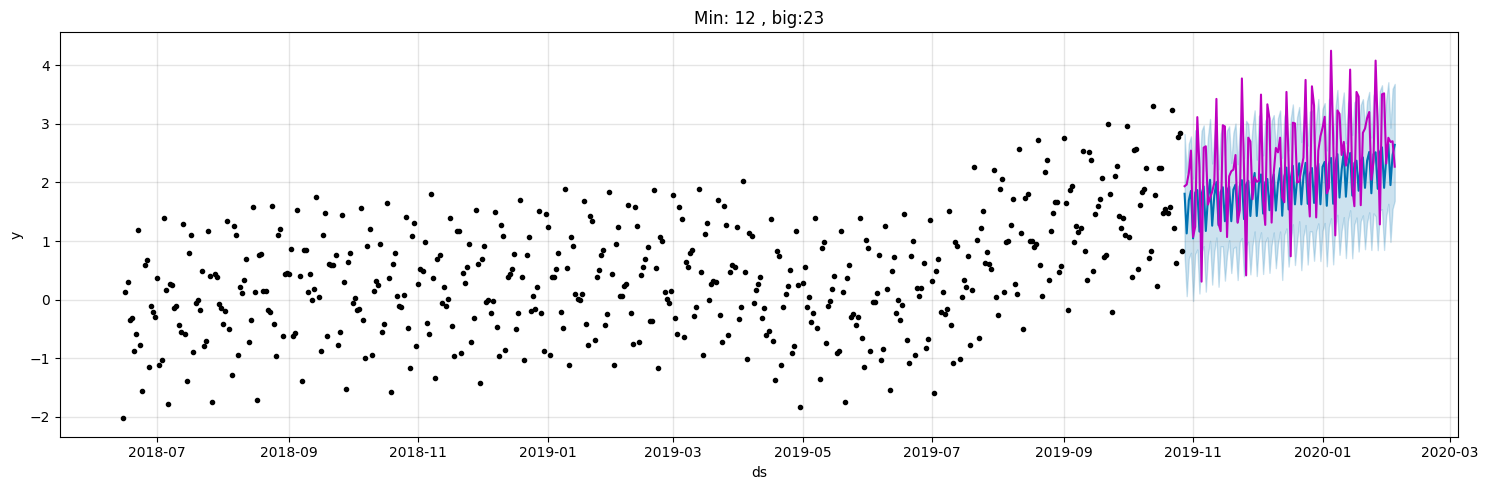

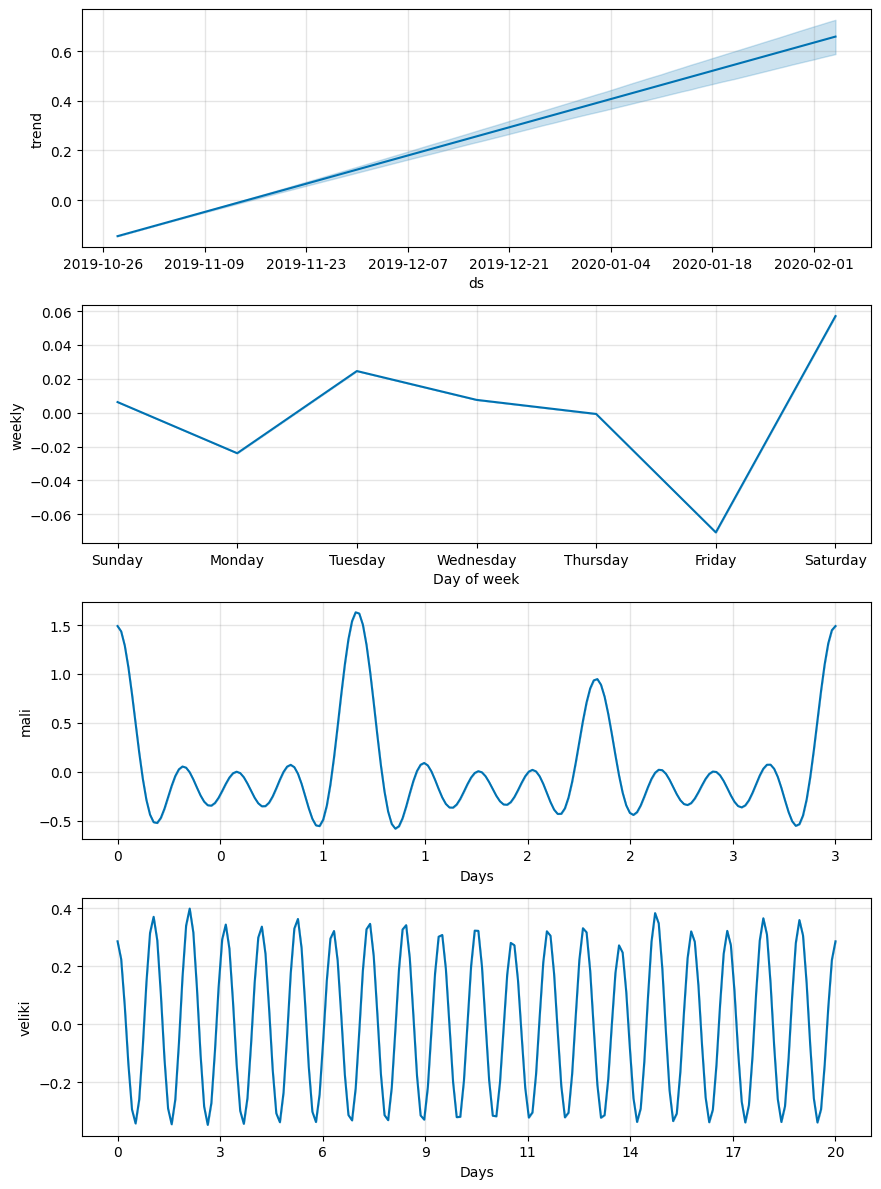

In [43]:
best_order_small=0
best_order_big=0
best_error=sys.maxsize

for f_order_small in [6, 8,10,12,14]:
    for f_order_big in [17, 19,21,23,25]:

        model = Prophet()
        model.add_seasonality(name='min', period=int(len(pts_df)/num_periods), fourier_order=f_order_small)
        model.add_seasonality(name='big', period=20, fourier_order=f_order_big)
        model.fit(pts_train_data)
        pred = model.predict(df=pts_test_data)

        y_pred = pred['yhat']
        y_true = pts_test_data['y'].values

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        print("Fourier order small: "+str(f_order_small))
        print("Fourier order big: "+str(f_order_big))
        print("RMSE: "+str(rmse))
        print("MAE: "+str(mae))
        print()

        if rmse < best_error:
            best_order_small=f_order_small
            best_order_big=f_order_big
            best_error=rmse

print()
print("Najbolji parametri:")
print("Fourier order small: "+str(best_order_small))
print("Fourier order big: "+str(best_order_big))

model = Prophet()
model.add_seasonality(name='mali', period=int(len(pts_df)/num_periods), fourier_order=best_order_small)
model.add_seasonality(name='veliki', period=20, fourier_order=best_order_big)
model.fit(pts_train_data)
pred = model.predict(df=pts_test_data)  

rmse = np.sqrt(mean_squared_error(pts_test, pred['yhat']))
mae = mean_absolute_error(pts_test,pred['yhat'])
print("RMSE: "+str(rmse))
print("MAE: "+str(mae))

figure, ax = plt.subplots(1)
plt.title("Min: "+str(best_order_small)+" , big:"+str(best_order_big))
figure.set_figheight(5)
figure.set_figwidth(15)
fig=model.plot(pred,ax=ax)
ax.plot(pts_test_data.ds, pts_test_data['y'], color='m')
plt.show()

fig = model.plot_components(pred)

Najbolji rezultati su za mali fourierov red 12, a veliki 23.